# Titre projet

# Introduction

In [560]:
from fredapi import Fred

from io import BytesIO

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches

import numpy as np
from numpy.linalg import svd

import pandas as pd
from pathlib import Path
from PIL import Image

import re
import requests
import random

import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import classification_report, balanced_accuracy_score, f1_score, log_loss
from sklearn.decomposition import PCA
from sklearn.svm import OneClassSVM
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import normalize
from scipy.spatial.distance import cdist
from scipy.special import expit

from typing import Optional, Dict, Tuple
import os

# from skfin.dataloaders.cache import CacheManager


# Section I

A central question in macro–finance is whether we can meaningfully identify and predict macroeconomic regimes, and whether these regimes have a stable and economically interpretable impact on asset-pricing factors. If factor returns truly depend on the underlying macro environment, then understanding—or even simply recognising—the current regime could provide a valuable foundation for dynamic portfolio construction. This project investigates precisely that idea: can we detect macro regimes from high-dimensional economic and monetary data, assess how factor premia vary across these regimes, and ultimately use this relationship to build portfolios that adapt to macroeconomic conditions?

## Methodology

The objective of this first section is to build a regime-aware asset-allocation framework that links macroeconomic conditions to the behaviour of standard equity factors. We start with a large macroeconomic dataset containing more than one hundred variables spanning the period from 1960 to 2025. To ensure a proper evaluation of predictive performance, the sample is split into a training set (1960–2015) and an out-of-sample test set (2016–2025). All variables are standardised using only the moments of the training sample, and the same transformation is applied to the test data to avoid any look-ahead bias.

To capture the main sources of variation in the macro data, we project the entire dataset onto a lower-dimensional space estimated exclusively from the training sample. Using the principal components of the training set, we then cluster the macroeconomic environment into a small number of regimes (between two and five). These regimes, learned in an unsupervised manner, correspond to persistent and economically interpretable states of the macroeconomy. Once the regimes are identified, we train a supervised model on the training period to map macroeconomic observations to regime labels. This model is then applied to the test period to obtain real-time regime classifications.

With predicted regimes in hand, we compute the conditional moments—means, volatilities, and covariances—of equity factor returns for each regime. These conditional moments serve as the building blocks for constructing dynamic Markowitz portfolios. At each date, the predicted regime determines which set of factor moments is used to form the tangency portfolio. This produces a regime-dependent allocation that adapts its exposure to pro-cyclical or defensive styles depending on the macroeconomic environment. We benchmark this regime-aware Markowitz strategy against a naïve equal-weight portfolio.

The goal of this methodology is not solely to forecast future regimes, but also to recognise the current macroeconomic state and exploit the historically observed behaviour of factors under similar conditions. By linking macro regimes to factor moments, the framework provides a systematic and economically intuitive approach to dynamic asset allocation.


Avoiding look-ahead bias became essential, as we had to carefully filter out biases present in both the datasets we used and the papers that inspired our approach.

**Look-ahead bias** occurs when a model, algorithm, or strategy uses information that would not have been available at the time the decision was made. Models that suffer from it appear profitable in backtests but cannot be implemented in real time, leading to misleading conclusions. In machine learning, this type of information leak is usually called data leakage, especially when future information leaks into the feature set.

A major source of concern in empirical studies using FRED-MD is the widespread presence of look-ahead bias, which often arises because many academic works implicitly treat macroeconomic variables as if they were known in real time. In practice, however, these series are subject to publication lags and subsequent revisions, meaning that their “final” values were not available to investors at the time decisions were made. To partially mitigate this issue, we shift a subset of the macroeconomic variables by one month relative to the financial data, so that the information set used for prediction more closely reflects what would have been observable in real time. 

Furthermore, we avoid additional look-ahead bias by performing all preprocessing steps strictly within the training sample: both the standardization of the variables and the PCA decomposition are fitted exclusively on the training set and then applied to the test set. This ensures that no future information leaks into the model during feature construction.

## Data preprocessing

### FRED-MD dataset

The FRED-MD dataset (Federal Reserve Economic Data – Monthly Database) is a widely used macroeconomic dataset maintained by the Federal Reserve Bank of St. Louis. It contains a broad panel of monthly U.S. macroeconomic and financial time series, covering areas such as output, labor markets, housing, consumption, inflation, interest rates, and asset prices. Each column represents one macroeconomic variable, while rows correspond to monthly observations. The first row of the dataset provides transformation codes, which specify how each series should be transformed (for example, log, first difference, or growth rate) before analysis to ensure stationarity. The dataset is updated monthly and is commonly used in empirical macroeconomic research, forecasting, and machine learning applications in finance and economics.

In [561]:
# --- Load main dataset (FRED-MD monthly macro data) ---
url_data = "https://raw.githubusercontent.com/lxsd111/ML_PM/main/nbs/data/2025-09-MD.csv"
fred = pd.read_csv(url_data, index_col=0)

# --- Separate transformation "tcodes" (first row) and actual data (remaining rows) ---
fred_data = fred.iloc[1:,:].copy()
fred_code = fred.iloc[0,:].copy()

# --- Convert index to datetime ---
fred_data.index = pd.to_datetime(fred_data.index, format="%m/%d/%Y")

print(fred_data.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 800 entries, 1959-01-01 to 2025-08-01
Columns: 126 entries, RPI to VIXCLSx
dtypes: float64(102), int64(24)
memory usage: 793.8 KB
None


The FRED-MD dataset contains 800 monthly observations ranging from January 1959 to August 2025, covering 126 macroeconomic variables. Among these variables, 102 are stored as floating-point values and 24 as integers, representing a diverse set of economic and financial indicators.

This preprocessing step aims to partially address publication lag issues in the FRED-MD dataset — i.e., the fact that some macroeconomic indicators are released with delays relative to others. For each remaining series, the code identifies how many missing values (NaN) appear at the end of the sample, which typically reflects unavailable recent data. Each affected series is then shifted forward by the corresponding number of months, effectively aligning its last valid observation with the latest available period. This ensures a more realistic timing structure by avoiding the use of data that would not have been known at the time (reducing look-ahead bias). Finally, the sample is restricted to observations starting from May 1962 to ensure consistency across variables. Moreover, a few variables with too many missing values (ACOGNO, TWEXAFEGSMTHx, UMCSENTx, ANDENOx) are removed from the dataset.

In [562]:
# --- Drop variables with too many missing values ---
cols_to_drop = ["ACOGNO", "TWEXAFEGSMTHx", "UMCSENTx", "ANDENOx"]
fred_data = fred_data.drop(columns=cols_to_drop, errors="ignore").copy()

# --- Function: count consecutive NaN values at the end of a series ---
def trailing_nans(s: pd.Series) -> int:
    """Count the number of consecutive NaN values at the end of a Series."""
    if not s.isna().any():
        return 0
    return int(np.argmax(~s[::-1].isna().values)) if s.isna().any() else 0

# --- Identify variables with trailing NaNs ---
nan_trails = {col: trailing_nans(fred_data[col]) for col in fred_data.columns}
nan_trails = {k: v for k, v in nan_trails.items() if v > 0}

# --- Shift series forward by 'n' months if they have n trailing NaNs ---
for col, lag in nan_trails.items():
    if lag > 0:
        fred_data[col] = fred_data[col].shift(lag)

# --- Restrict the sample to ensure consistent coverage across variables ---
fred_data = fred_data.loc[fred_data.index >= "1962-05-01"]

print(f"\nFinal dataset size: {fred_data.shape[0]} observations, {fred_data.shape[1]} variables")


Final dataset size: 760 observations, 122 variables


Apart from VIX, the dataset contained only two missing values, which we handled with forward fill (ffill). Any remaining NaNs are in VIX and will be treated later during the transformation step.

In [563]:
fred_data = fred_data.fillna(method="ffill")

C:\Users\user\AppData\Local\Temp\ipykernel_27892\2309531013.py:1: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  fred_data = fred_data.fillna(method="ffill")


Each variable in the **FRED-MD** dataset is associated with a *transformation code* (`tcode`), which specifies how the raw series should be transformed before analysis to achieve stationarity and comparability across variables.  

The transformation rules, as defined by McCracken and Ng (2016), are as follows:

| Code | Transformation | Description |
|:----:|:------------------------------|:-----------------------------------------------|
| 1 | *No transformation* | Use the level of the series as is |
| 2 | $\Delta x_t$ | First difference of the raw series |
| 3 | $\Delta^2 x_t$ | Second difference of the raw series |
| 4 | $\log(x_t)$ | Natural logarithm of the level |
| 5 | $\Delta \log(x_t)$ | First difference of the logarithm (approximate growth rate) |
| 6 | $\Delta^2 \log(x_t)$ | Second difference of the logarithm |
| 7 | $\Delta \left(\frac{x_t}{x_{t-1}} - 1\right)$ | Change in the growth rate (ratio form) |

These transformations are applied to ensure that most macroeconomic series are **stationary** before being used in empirical models such as factor analysis or forecasting.  
Variables marked with an asterisk (*) in the FRED-MD documentation indicate that minor adjustments were made relative to their original FRED source (see McCracken & Ng, *"FRED-MD: A Monthly Database for Macroeconomic Research"*, 2016).


In [564]:
# --- Normalize column names to ensure alignment between data and codes ---
fred_data.columns = fred_data.columns.str.upper()
# fred_code is a single-row DataFrame or a Series with tcodes per column
tcode_map = fred_code.squeeze()                    # to Series if single row
tcode_map.index = tcode_map.index.str.upper()      # align names
tcode_map = pd.to_numeric(tcode_map, errors="coerce")

# --- Container for transformed series ---
df_transformed = pd.DataFrame(index=fred_data.index)

# --- Apply McCracken–Ng tcodes where available; otherwise keep series as is ---
for col in fred_data.columns:
    s = fred_data[col]
    code = tcode_map.get(col, np.nan)  # NaN => no code available

    if pd.isna(code):
        # No transformation code: keep original series
        s_tr = s
    else:
        code = int(code)
        if code == 1:
            s_tr = s
        elif code == 2:
            s_tr = s.diff()
        elif code == 3:
            s_tr = s.diff().diff()
        elif code == 4:
            # Log of levels; guard against non-positive values
            s_tr = s.where(s > 0)
            s_tr = np.log(s_tr)
        elif code == 5:
            # First difference of log (approximate growth rate)
            s_tr = s.where(s > 0)
            s_tr = np.log(s_tr).diff()
        elif code == 6:
            # Second difference of log
            s_tr = s.where(s > 0)
            s_tr = np.log(s_tr).diff().diff()
        else:
            # Δ(x_t / x_{t-1} - 1)
            r = s / s.shift(1) - 1
            s_tr = r.diff()

    df_transformed[col] = s_tr

C:\Users\user\AppData\Local\Temp\ipykernel_27892\3549416829.py:44: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_transformed[col] = s_tr
C:\Users\user\AppData\Local\Temp\ipykernel_27892\3549416829.py:44: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_transformed[col] = s_tr
C:\Users\user\AppData\Local\Temp\ipykernel_27892\3549416829.py:44: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once usi

In addition to working with the full macroeconomic dataset, we also construct a reduced “Dataset Bis” composed of a subset of variables that we consider particularly relevant for capturing the main dimensions of the macro–financial environment. While the full dataset will later be processed through PCA to extract its dominant sources of variation, this smaller subset allows us to test the robustness of our results and to experiment with a more interpretable feature set.

The selected variables are intentionally centred on central‐bank activity and the transmission of monetary policy. They cover the key macroeconomic dimensions that central banks monitor and influence: real-economy indicators (industrial production, unemployment, claims, housing), monetary aggregates (M1, M2, the monetary base), banking and credit conditions (business loans, non-borrowed reserves), the entire interest-rate structure shaped by policy expectations, and inflation measures, which sit at the core of monetary mandates. We also include essential financial-market indicators—equity valuations, dividend yields, and implied volatility—that react strongly to policy decisions and risk-premium adjustments. By focusing on this central-bank-related subset, we aim to isolate the macro-monetary forces most relevant for policy cycles and liquidity conditions, and to assess whether these alone can generate meaningful and interpretable regimes. This reduced dataset serves as a complementary benchmark to the full PCA-based approach and allows us to test whether factor behaviour is primarily driven by the central-bank and monetary-policy environment rather than by the broader macro landscape.

In [565]:
# List of selected variables
cols_bis = [
    "RPI", "UNRATE", "CLAIMSX", "HOUST", "PERMIT", "DPCERA3M086SBEA",
    "ISRATIOX", "M1SL", "M2SL", "BOGMBASE", "NONBORRES", "CONSPI",
    "BUSLOANS", "FEDFUNDS", "T1YFFM", "T5YFFM", "T10YFFM", "AAAFFM",
    "BAAFFM", "OILPRICEX", "CPIAUCSL", "CUSR0000SAS",
    "S&P 500", "S&P DIV YIELD", "S&P PE RATIO", "VIXCLSX"
]

# Extract the reduced dataset
df_bis = df_transformed[cols_bis].copy()

Applying the transformations resulted in the loss of the first two observations — since differencing operations (Δxₜ, Δ²xₜ, etc.) naturally reduce the sample size — so the dataset now starts in July 1962.

The dataset is then split at January 2016: this cutoff is economically meaningful, as it separates the post–Global Financial Crisis and monetary normalization period from earlier decades, while also providing a sufficiently large historical window for robust machine learning tasks such as clustering, dimensionality reduction, and model training.

In [566]:
# --- Define temporal boundaries for the analysis ---
START_DATE = "1962-07-01"   
END_DATE   = "2025-08-01"  
SPLIT_DATE = "2016-01-01"   # split point for in-sample (IS) vs out-of-sample (OOS)

# Restrict dataset to the analysis period
df_transformed = df_transformed.loc[df_transformed.index >= START_DATE]

# --- Split the dataset into in-sample (IS) and out-of-sample (OOS) periods ---
fred_IS  = df_transformed.loc[:SPLIT_DATE].copy()   
fred_OOS = df_transformed.loc[SPLIT_DATE:].copy()   

fred_IS_bis = df_bis.loc[START_DATE:SPLIT_DATE].copy()
fred_OOS_bis = df_bis.loc[SPLIT_DATE:END_DATE].copy()

The data are standardized using a StandardScaler, which removes the mean and scales each feature to unit variance — a necessary step for PCA, since principal components are sensitive to variable magnitudes. The scaler is fitted on the in-sample (IS) data to capture the historical distribution of each variable, and then applied to the out-of-sample (OOS) data to ensure consistent scaling without leaking future information.

In [567]:
# --- Standardize the data (zero mean, unit variance) ---
scaler = StandardScaler()

fred_IS_std = pd.DataFrame(
    scaler.fit_transform(fred_IS),
    index=fred_IS.index,
    columns=fred_IS.columns
)

fred_OOS_std = pd.DataFrame(
    scaler.transform(fred_OOS),
    index=fred_OOS.index,
    columns=fred_OOS.columns
)

# --- Dataset "bis" ---
scaler_bis = StandardScaler()
fred_IS_bis = pd.DataFrame(
    scaler_bis.fit_transform(fred_IS_bis),
    index=fred_IS_bis.index,
    columns=fred_IS_bis.columns
)

fred_OOS_bis = pd.DataFrame(
    scaler_bis.transform(fred_OOS_bis),  # moments de train_bis seulement
    index=fred_OOS_bis.index,
    columns=fred_OOS_bis.columns
)

### Industry Portfolios

The 12 Industry Portfolios from Kenneth French’s data library provide monthly returns for twelve broad U.S. industry groups, constructed using firms listed on major U.S. exchanges and sorted based on their SIC codes. Each column corresponds to an industry portfolio (such as Consumer Durables, Manufacturing, Energy, Chemicals, etc.), and the values represent value-weighted returns expressed in percentage form. 

This section loads the 12 Industry Portfolios from Kenneth French’s data library, cleans the dataset, and prepares it for empirical analysis. The sample is divided into an in-sample period used for model estimation and an out-of-sample period reserved for evaluating predictive performance. 

In [568]:
# URL to the ZIP file containing Ken French's 12 Industry Portfolios
url = "https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/ftp/12_Industry_Portfolios_CSV.zip"

# Load the CSV file 
indus_df = pd.read_csv(url, skiprows=11)
indus_df.columns.values[0] = "Date"
indus_df.set_index("Date", inplace=True)

# Keep only the monthly observations up to row 1191 (before missing values appear)
indus_df = indus_df.iloc[:1191].copy()
indus_df.index = pd.to_datetime(indus_df.index.astype(str), format="%Y%m")
indus_df = indus_df.astype(float) / 100.0

# Split the dataset into in-sample (IS) and out-of-sample (OOS)
indus_all  = indus_df.loc[START_DATE:].astype(float).copy()
indus_IS  = indus_df.loc[START_DATE:SPLIT_DATE].astype(float).copy()
indus_OOS = indus_df.loc[SPLIT_DATE:END_DATE].astype(float).copy()

# Simple cumulative sum (additive approximation)
indus_cum = indus_df.cumsum()

### Fama–French style factors

The factor data are sourced from Kenneth French’s Data Library, which provides long-horizon, research-grade monthly time series widely used in empirical asset pricing. The dataset includes five well-known Fama–French style factors: **SMB**, **HML**, **RMW**, **CMA**, and **MOM**, each representing a distinct compensated source of risk in cross-sectional equity returns. **SMB** (Small Minus Big) captures the size premium by measuring the performance spread between small-cap and large-cap stocks. **HML** (High Minus Low) reflects the value premium by comparing returns of high book-to-market firms to low book-to-market firms. **RMW** (Robust Minus Weak) measures the profitability premium, contrasting firms with strong operating profitability against those with weak profitability. **CMA** (Conservative Minus Aggressive) represents the investment premium based on differences in corporate investment policies. Finally, **MOM** (Momentum) captures the well-documented tendency for stocks with strong past performance to continue outperforming in the near term. Together, these factors form a comprehensive framework for explaining and modeling the cross-section of expected equity returns.


In [569]:
# Fama-French 5 Factors + Momentum (MKT, SMB, HML, RMW, CMA, MOM)
url = "https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/ftp/F-F_Research_Data_5_Factors_2x3_CSV.zip"
ff5 = pd.read_csv(url, skiprows=3)

# Clean column names and keep only rows corresponding to YYYYMM dates
ff5 = ff5.rename(columns={ff5.columns[0]: "Date"})
ff5.columns = ff5.columns.str.strip()
ff5 = ff5[ff5["Date"].astype(str).str.fullmatch(r"\d{6}", na=False)].copy()

# Convert the Date column to datetime and set it as index
ff5["Date"] = pd.to_datetime(ff5["Date"], format="%Y%m")
ff5 = ff5.set_index("Date")

# Convert all factor values from percent to decimal
ff5 = ff5.astype(float) / 100  

# --- Momentum (MOM) ---
url_mom = "https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/ftp/F-F_Momentum_Factor_CSV.zip"
mom = pd.read_csv(url_mom, skiprows=13)

# Clean column names and the Date column
mom = mom.rename(columns={mom.columns[0]: "Date"})
mom.columns = mom.columns.str.strip()

# Keep only rows corresponding to YYYYMM dates (ignore invalid rows)
mom = mom[mom["Date"].astype(str).str.fullmatch(r"\d{6}", na=False)].copy()

# Convert Date to datetime and numerical values to floats
mom["Date"] = pd.to_datetime(mom["Date"], format="%Y%m")
mom = mom.set_index("Date")
mom = mom.apply(pd.to_numeric, errors="coerce") / 100

# Standardize the momentum column name (e.g., "Mom", " MOM ")
mom.columns = mom.columns.str.strip()
mom = mom.rename(columns={mom.columns[0]: "MOM"})

# --- Merge FF5 and Momentum ---
factors = ff5.join(mom[["MOM"]], how="inner")

# Drop excess columns (market excess return and risk-free rate)
factors = factors.drop(['Mkt-RF', 'RF'], axis=1)

# Split into in-sample (IS) and out-of-sample (OOS) windows
factors_all  = factors.loc[START_DATE:END_DATE].copy()
factors_IS  = factors.loc[START_DATE:SPLIT_DATE].copy()
factors_OOS = factors.loc[SPLIT_DATE:END_DATE].copy()
print(factors_all.head())

               SMB     HML     RMW     CMA     MOM
Date                                              
1963-07-01 -0.0048 -0.0081  0.0064 -0.0115  0.0101
1963-08-01 -0.0080  0.0170  0.0040 -0.0038  0.0100
1963-09-01 -0.0043  0.0000 -0.0078  0.0015  0.0012
1963-10-01 -0.0134 -0.0004  0.0279 -0.0225  0.0313
1963-11-01 -0.0085  0.0173 -0.0043  0.0227 -0.0078


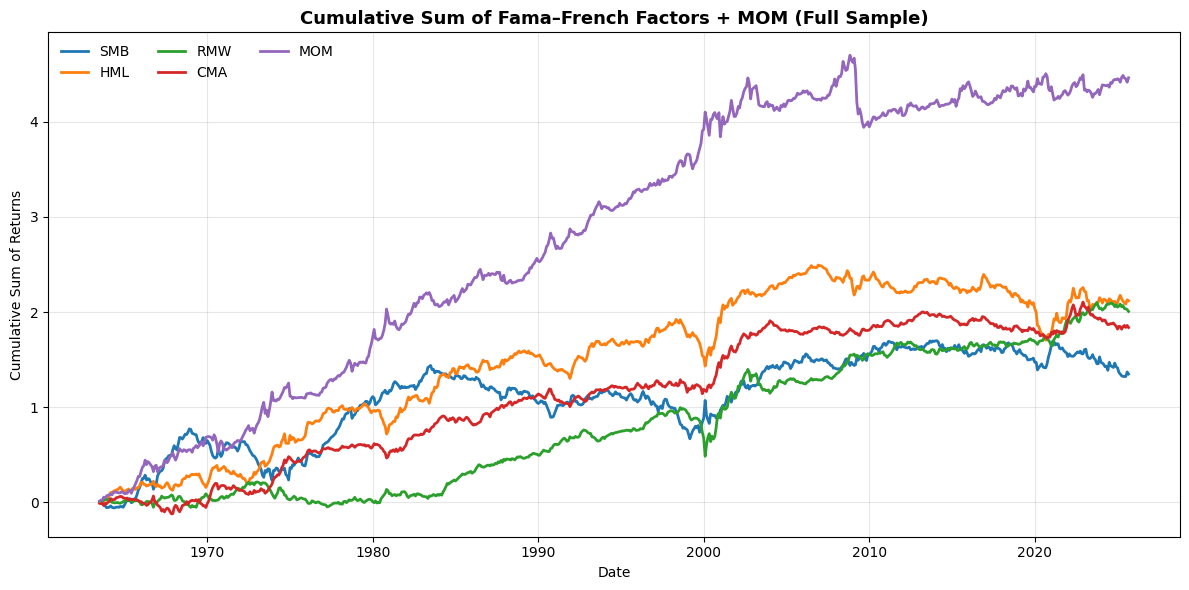

In [570]:
# Compute cumulative sums of all factor returns (already in decimal form)
ff_cum = factors.cumsum()

# Use all columns from the factors dataset
factor_cols = factors.columns

# Plot
plt.figure(figsize=(12,6))
palette = sns.color_palette("tab10", n_colors=len(factor_cols))

for i, col in enumerate(factor_cols):
    plt.plot(ff_cum.index, ff_cum[col], label=col, lw=2, color=palette[i % len(palette)])

plt.title("Cumulative Sum of Fama–French Factors + MOM (Full Sample)",
          fontsize=13, weight="bold")
plt.xlabel("Date")
plt.ylabel("Cumulative Sum of Returns")
plt.grid(alpha=0.3)
plt.legend(frameon=False, ncol=3)
plt.tight_layout()
plt.show()


## Macroeconomic Regime Detection

### Principal Component Analysis

We apply PCA on the training set to reduce the dimensionality of the macroeconomic dataset while retaining at least 85% of the total variance. This provides a compact set of orthogonal factors that capture the dominant sources of macroeconomic co-movement and improves the stability of downstream clustering and prediction.

Number of components retained: 28
Cumulative explained variance: 75.37%


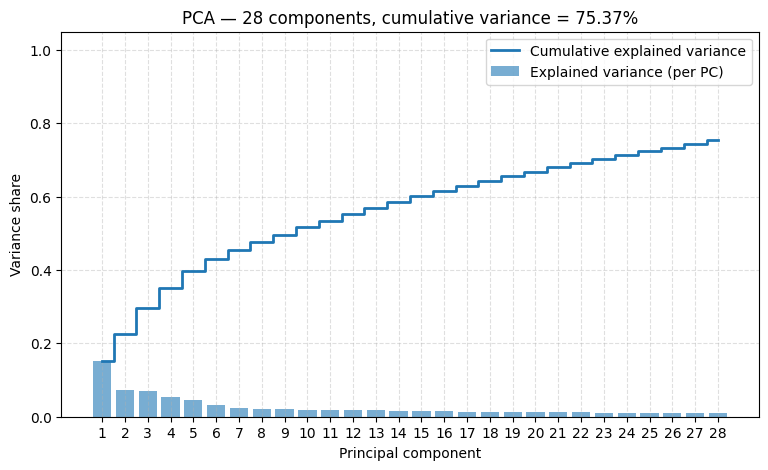

In [571]:
# Keep the minimum number of components explaining at least 85% of the variance
pca = PCA(n_components=0.75, svd_solver='full')

# --- Fit PCA on TRAIN only ---
# This learns the eigenvectors/eigenvalues from the training set
fred_PCA_IS = pd.DataFrame(
    pca.fit_transform(fred_IS_std),        # fit + transform on TRAIN
    index=fred_IS_std.index,
    columns=[f"PC{i+1}" for i in range(pca.n_components_)]
)

print(f"Number of components retained: {pca.n_components_}")
print(f"Cumulative explained variance: {pca.explained_variance_ratio_.sum():.2%}")

# --- Out-of-sample projection of TEST ---
# We apply the TRAIN PCA transformation to the TEST data (no refitting)
fred_PCA_OOS = pd.DataFrame(
    pca.transform(fred_OOS_std),           # pure transform on TEST
    index=fred_OOS_std.index,
    columns=fred_PCA_IS.columns
)

# (Optional) Reconstruct a full PCA series (TRAIN + TEST) in the same PCA space
fred_PCA = pd.concat([fred_PCA_IS, fred_PCA_OOS]).sort_index()

evr = pca.explained_variance_ratio_         # variance explained by each PC
evr_cum = np.cumsum(evr)                    # cumulative explained variance
k = pca.n_components_

plt.figure(figsize=(9, 5))

# Variance explained per component
plt.bar(np.arange(1, k+1), evr, alpha=0.6, label='Explained variance (per PC)')

# Cumulative explained variance curve
plt.step(np.arange(1, k+1), evr_cum, where='mid', linewidth=2.0,
         label='Cumulative explained variance')

plt.xlabel('Principal component')
plt.ylabel('Variance share')
plt.title(f'PCA — {k} components, cumulative variance = {evr_cum[-1]:.2%}')
plt.xticks(np.arange(1, k+1, max(1, k//20)))
plt.ylim(0, 1.05)
plt.grid(True, linestyle='--', alpha=0.4)
plt.legend()
plt.show()
plt.close()


### Gaussian Mixture Models


Gaussian Mixture Models offer several advantages for regime detection. They provide probabilistic regime assignments, which better reflect the gradual and uncertain nature of economic transitions. Because each regime has its own mean and covariance matrix, GMMs can capture differences in volatility, correlations, and distribution shapes across states—features that simple clustering methods like K-means cannot model. 

However, GMMs also come with limitations. They rely on a Gaussian assumption that may be restrictive for heavy-tailed or skewed macro-financial data. They treat observations as independent, ignoring the persistence and transition dynamics inherent to business cycles—features better handled by Hidden Markov Models.

The choice of the number of regimes and their economic interpretation will be discussed in the final section.

**PCA–GMM**

We apply a Gaussian Mixture Model (GMM) to the PCA-transformed training data in order to identify latent macroeconomic regimes. By clustering the historical observations into probabilistic states, the GMM provides a flexible and data-driven representation of distinct macro environments that can later be used for forecasting and portfolio construction.

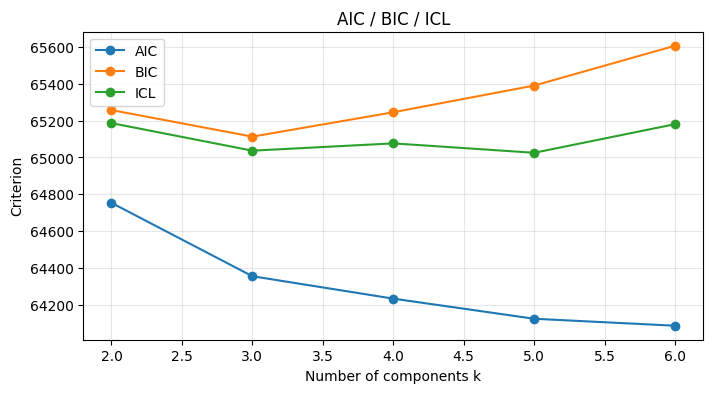

In [572]:
k_candidates = range(2, 7)
rows = []
models = {}

for k_ in k_candidates:
    # Fit a Gaussian Mixture with k components on PCA-transformed TRAIN data
    g = GaussianMixture(
        n_components=k_,
        covariance_type="diag",
        n_init=10,
        reg_covar=1e-6,
        random_state=42
    ).fit(fred_PCA_IS)

    # Standard information criteria
    aic = g.aic(fred_PCA_IS)
    bic = g.bic(fred_PCA_IS)

    # Posterior probabilities and entropy term
    tau = np.clip(g.predict_proba(fred_PCA_IS), 1e-12, 1.0)
    entropy = -np.sum(tau * np.log(tau))        # >= 0

    # Integrated Completed Likelihood (ICL): lower is better
    icl = bic - 2.0 * entropy

    rows.append({
        "k": k_,
        "loglik": g.lower_bound_,               # average log-likelihood
        "AIC": aic,
        "BIC": bic,
        "Entropy": entropy,
        "ICL": icl
    })

    models[k_] = g

# Build DataFrame of criteria
ic_df = pd.DataFrame(rows).set_index("k")

# plot for visual comparison
plt.figure(figsize=(8, 4))
for col in ["AIC", "BIC", "ICL"]:
    plt.plot(ic_df.index, ic_df[col], marker='o', label=col)
plt.xlabel("Number of components k")
plt.ylabel("Criterion")
plt.title("AIC / BIC / ICL")
plt.grid(alpha=0.3)
plt.legend()
plt.show()

# Manual choice of the number of regimes
chosen_k = 2
gmm = models[chosen_k]

# Check that the GMM converged
if hasattr(gmm, "converged_") and not gmm.converged_:
    print("Warning: GMM did not converge.")

# In-sample predictions
labels_tr = gmm.predict(fred_PCA_IS)            # hard regime labels
probas_tr = gmm.predict_proba(fred_PCA_IS)      # soft regime probabilities
llk_tr    = gmm.score_samples(fred_PCA_IS)      # pointwise log-likelihood

# Build a labelled time series for plotting / analysis
reg_gmm_IS = pd.Series(labels_tr, index=fred_PCA_IS.index, name="gmm_label").astype(int)
reg_gmm_IS = reg_gmm_IS + 1   # to start at 1 instead of 0


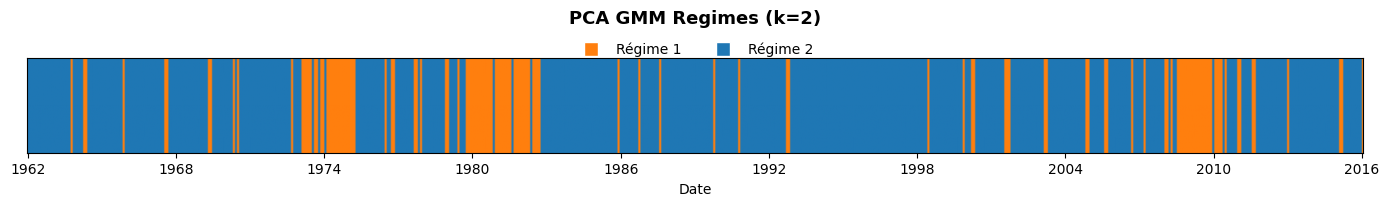

In [573]:
labels = reg_gmm_IS.values
dates  = reg_gmm_IS.index
n_regimes = reg_gmm_IS.max()

# use 0..K-1 as values for the colormap, but keep labels as 1..K
Z = (labels - 1).reshape(1, -1)

palette = sns.color_palette("tab10", n_colors=n_regimes)
random.shuffle(palette)
cmap = ListedColormap(palette)


plt.figure(figsize=(14, 2.6))

plt.imshow(Z, aspect="auto", cmap=cmap)
plt.yticks([])

# x-axis with a few year ticks
plt.xticks(
    ticks=np.linspace(0, len(dates) - 1, 10),
    labels=pd.to_datetime(
        np.linspace(dates[0].value, dates[-1].value, 10)
    ).strftime("%Y")
)

plt.title(
    f"PCA GMM Regimes (k={n_regimes})",
    fontsize=13,
    weight="bold",
    pad=25
)
plt.xlabel("Date")

# legend: Régime 1..K, using the right color
handles = [
    plt.Line2D(
        [0], [0],
        marker="s",
        color="w",
        label=f"Régime {k}",
        markerfacecolor=palette[k - 1],
        markersize=10
    )
    for k in range(1, n_regimes + 1)
]

plt.legend(
    handles=handles,
    loc="upper center",
    bbox_to_anchor=(0.5, 1.30),
    ncol=n_regimes,
    frameon=False
)

plt.tight_layout(rect=[0, 0, 1, 0.85])
plt.show()

In [574]:
# ----------------------------
# In-sample diagnostics 
# ----------------------------

# Total log-likelihood on the training set
loglik_train = gmm.score(fred_PCA_IS) * len(fred_PCA_IS)

# Posterior regime probabilities (responsibilities)
tau_train = probas_tr  # already computed above

# Average entropy of regime probabilities (lower = clearer regimes)
entropy_train = -(tau_train * np.log(tau_train + 1e-12)).sum(axis=1).mean()

# Average purity: mean of max_k tau_{ik} (higher = clearer regimes)
purity_train = tau_train.max(axis=1).mean()

print("\n=== GMM quality ===")
print(f"Total log-likelihood (train) : {loglik_train:,.2f}")
print(f"Average entropy (train)      : {entropy_train:.4f}")
print(f"Average purity (train)       : {purity_train:.4f}")

# ----------------------------
# Clustering stability: refit GMM and compare labels (ARI)
# ----------------------------

# Reference hard labels from the original GMM (bis)
labels_ref = labels

# Refit another GMM with the same hyperparameters but a different random seed
gmm_alt = GaussianMixture(
    n_components=chosen_k,
    covariance_type="diag",
    n_init=10,
    reg_covar=1e-6,
    random_state=123  # different seed from the original fit (42)
).fit(fred_PCA_IS)

labels_alt = gmm.predict(fred_PCA_IS)

# Adjusted Rand Index: similarity between two partitions (higher = more stable)
ari = adjusted_rand_score(labels_alt, labels_alt)

print("\n=== Regime stability (TRAIN bis) ===")
print(f"Adjusted Rand Index (ARI)    : {ari:.3f}")



=== GMM quality ===
Total log-likelihood (train) : -32,263.64
Average entropy (train)      : 0.0552
Average purity (train)       : 0.9789

=== Regime stability (TRAIN bis) ===
Adjusted Rand Index (ARI)    : 1.000


**GMM Quality (In-Sample, PCA, k = 2)**

The model achieves a total log-likelihood of -32,263.64, which reflects a stable fit for a 2-component Gaussian mixture on the PCA-transformed data. The average entropy is extremely low (0.0552), indicating that regime assignments are made with very high confidence and that posterior probabilities are highly concentrated. This is confirmed by the high average purity (0.9789), meaning that most observations are classified almost unambiguously into one of the two regimes. The Adjusted Rand Index (ARI) equals 1.000, showing perfectly consistent assignments across repeated fits, and therefore very strong in-sample stability of the GMM clustering structure.

**GMM Quality (In-Sample, PCA, k = 4)**

The model achieves a total log-likelihood of -31,889.14, indicating a stable fit for a four-component Gaussian mixture. The average entropy is low (0.1316), showing that regime assignments remain relatively confident despite the larger number of components. The average purity (0.9513) confirms that most observations are still allocated to their dominant regime with high probability, although slightly less sharply than in the two-regime specification. The Adjusted Rand Index (ARI) equals 0.907, reflecting high internal stability across repeated fits. This indicates that the four-regime structure is consistently recovered and not overly sensitive to random initialization.

**Reduced data-set GMM**

We apply a Gaussian Mixture Model (GMM) to the reduced set of selected macroeconomic variables in order to identify latent regimes directly in the original economic space. By clustering the historical observations using this curated subset of indicators, the GMM captures distinct macroeconomic environments in a more interpretable and economically grounded manner, providing a complementary regime representation that can later be used for forecasting and portfolio construction.

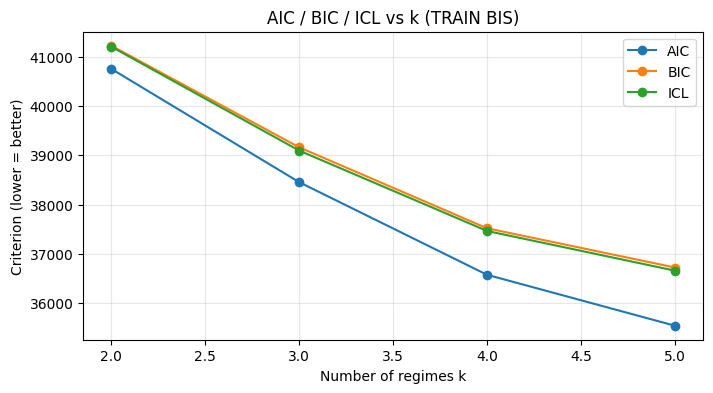

In [575]:
# Information criteria (AIC / BIC / ICL) for k = 2..5 on BIS dataset
k_candidates_bis = range(2, 6)
rows_bis = []
models_bis = {}

for k_ in k_candidates_bis:
    
    # Fit a Gaussian Mixture on the BIS in-sample dataset
    gmm_bis_k = GaussianMixture(
        n_components=k_,
        covariance_type="diag",
        n_init=10,
        reg_covar=1e-6,
        random_state=331
    ).fit(fred_IS_bis)

    # Standard information criteria (evaluated on train_bis)
    aic_bis = gmm_bis_k.aic(fred_IS_bis)
    bic_bis = gmm_bis_k.bic(fred_IS_bis)

    # Posterior probabilities and global entropy
    tau_bis = np.clip(gmm_bis_k.predict_proba(fred_IS_bis), 1e-12, 1.0)
    ent_bis = -(tau_bis * np.log(tau_bis)).sum()     # Global entropy (>= 0)

    # ICL criterion (lower = better)
    icl_bis = bic_bis - 2.0 * ent_bis

    # Store metrics
    rows_bis.append({
        "k": k_,
        "loglik": gmm_bis_k.lower_bound_,   # average log-likelihood
        "AIC": aic_bis,
        "BIC": bic_bis,
        "ENT": ent_bis,
        "ICL": icl_bis
    })

    # Store fitted model
    models_bis[k_] = gmm_bis_k


# Build DataFrame of information criteria
ic_df_bis = pd.DataFrame(rows_bis).set_index("k")

# Optional visualization
plt.figure(figsize=(8, 4))
for col in ["AIC", "BIC", "ICL"]:
    plt.plot(ic_df_bis.index, ic_df_bis[col], marker="o", label=col)

plt.xlabel("Number of regimes k")
plt.ylabel("Criterion (lower = better)")
plt.title("AIC / BIC / ICL vs k (TRAIN BIS)")
plt.grid(alpha=0.3)
plt.legend()
plt.show()


# Select the number of regimes and retrieve the GMM model
chosen_k_bis = 2
gmm_bis = models_bis[chosen_k_bis]

# Basic convergence check
if hasattr(gmm_bis, "converged_") and not gmm_bis.converged_:
    print("Warning: GMM (bis) did not converge.")

# Hard labels
labels_tr_bis = gmm_bis.predict(fred_IS_bis)
labels_te_bis = gmm_bis.predict(fred_OOS_bis)

# Soft probabilities
probas_tr_bis = gmm_bis.predict_proba(fred_IS_bis)
probas_te_bis = gmm_bis.predict_proba(fred_OOS_bis)

# Pointwise log-likelihood
llk_tr_bis = gmm_bis.score_samples(fred_IS_bis)
llk_te_bis = gmm_bis.score_samples(fred_OOS_bis)


# Indexed regime series (regimes start at 1)
reg_gmm_IS_bis = pd.Series(
    labels_tr_bis + 1,
    index=fred_IS_bis.index,
    name="regime_bis"
).astype(int)

reg_gmm_OOS_bis = pd.Series(
    labels_te_bis + 1,
    index=fred_OOS_bis.index,
    name="regime_bis"
).astype(int)


# diagnostic DataFrames (train & test)
gmm_diag_train_bis = (
    pd.DataFrame(
        probas_tr_bis,
        index=fred_IS_bis.index,
        columns=[f"p_regime_{i+1}_bis" for i in range(chosen_k_bis)]
    )
    .assign(loglik=llk_tr_bis, regime=reg_gmm_IS_bis)
)

gmm_diag_test_bis = (
    pd.DataFrame(
        probas_te_bis,
        index=fred_OOS_bis.index,
        columns=[f"p_regime_{i+1}_bis" for i in range(chosen_k_bis)]
    )
    .assign(loglik=llk_te_bis, regime=reg_gmm_OOS_bis)
)


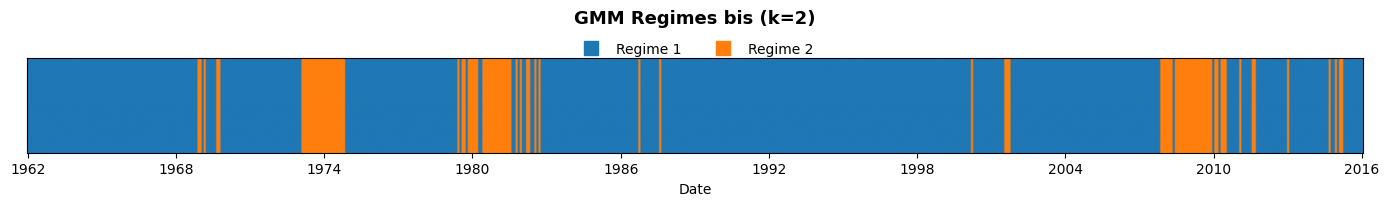

In [576]:
# --- Data preparation ---
dates = reg_gmm_IS_bis.index
labels = reg_gmm_IS_bis.values          # labels already between 1 and k
n_regimes = labels.max()                # number of regimes

# Transform the series into a 1 × T matrix for imshow
Z = labels.reshape(1, -1)

palette = sns.color_palette("tab10", n_colors=n_regimes)
random.shuffle(palette)
cmap = ListedColormap(palette)

# --- Figure ---
plt.figure(figsize=(14, 2.6))

# Horizontal heatmap
plt.imshow(Z, aspect="auto", cmap=cmap)

plt.yticks([])

# Time ticks: 10 evenly spaced years
plt.xticks(
    ticks=np.linspace(0, len(dates) - 1, 10),
    labels=pd.to_datetime(
        np.linspace(dates[0].value, dates[-1].value, 10)
    ).strftime("%Y")
)

# Clean title
plt.title(
    f"GMM Regimes bis (k={n_regimes})",
    fontsize=13,
    weight="bold",
    pad=25
)

plt.xlabel("Date")

# --- Legend with one color per regime ---
handles = [
    plt.Line2D([0], [0], marker="s", linestyle="",
               color=palette[k-1], label=f"Regime {k}", markersize=10)
    for k in range(1, n_regimes + 1)
]

plt.legend(
    handles=handles,
    loc="upper center",
    bbox_to_anchor=(0.5, 1.30),
    ncol=n_regimes,
    frameon=False
)

# Clean margins
plt.tight_layout(rect=[0, 0, 1, 0.85])

plt.show()


In [577]:
# ----------------------------
# In-sample diagnostics 
# ----------------------------

# Total log-likelihood on the training set
loglik_train_bis = gmm_bis.score(fred_IS_bis) * len(fred_IS_bis)

# Posterior regime probabilities (responsibilities)
tau_train_bis = probas_tr_bis  # already computed above

# Average entropy of regime probabilities (lower = clearer regimes)
entropy_train_bis = -(tau_train_bis * np.log(tau_train_bis + 1e-12)).sum(axis=1).mean()

# Average purity: mean of max_k tau_{ik} (higher = clearer regimes)
purity_train_bis = tau_train_bis.max(axis=1).mean()

print("\n=== GMM quality (TRAIN bis) ===")
print(f"Total log-likelihood (train) : {loglik_train_bis:,.2f}")
print(f"Average entropy (train)      : {entropy_train_bis:.4f}")
print(f"Average purity (train)       : {purity_train_bis:.4f}")

# ----------------------------
# Clustering stability: refit GMM and compare labels (ARI)
# ----------------------------

# Reference hard labels from the original GMM (bis)
labels_ref_bis = labels_tr_bis

# Refit another GMM with the same hyperparameters but a different random seed
gmm_alt_bis = GaussianMixture(
    n_components=chosen_k_bis,
    covariance_type="diag",
    n_init=10,
    reg_covar=1e-6,
    random_state=123  # different seed from the original fit (42)
).fit(fred_IS_bis)

labels_alt_bis = gmm_alt_bis.predict(fred_IS_bis)

# Adjusted Rand Index: similarity between two partitions (higher = more stable)
ari_bis = adjusted_rand_score(labels_ref_bis, labels_alt_bis)

print("\n=== Regime stability (TRAIN bis) ===")
print(f"Adjusted Rand Index (ARI)    : {ari_bis:.3f}")



=== GMM quality (TRAIN bis) ===
Total log-likelihood (train) : -20,269.98
Average entropy (train)      : 0.0157
Average purity (train)       : 0.9950

=== Regime stability (TRAIN bis) ===
Adjusted Rand Index (ARI)    : 1.000


**GMM Quality (In-Sample, Reduced Dataset, k = 2)**

The model achieves a total log-likelihood of –20,269.98, indicating a stable fit for a 2-component Gaussian mixture on the reduced set of selected macroeconomic variables. The average entropy is extremely low (0.0157), showing that regime assignments are made with very high confidence and that posterior probabilities are strongly concentrated on a single regime. This is confirmed by the very high average purity (0.9950), meaning that almost all observations are classified in an essentially unambiguous way into one of the two regimes. The Adjusted Rand Index (ARI) equals 1.000, indicating perfectly consistent regime assignments across repeated fits and, therefore, very strong in-sample stability of the GMM clustering structure on the reduced dataset.

**GMM Quality (In-Sample, Reduced Dataset, k = 4)**

The model achieves a total log-likelihood of –18,078.44, indicating a stable fit for a four-component Gaussian mixture on the reduced macroeconomic dataset. The average entropy remains low (0.0429), suggesting that regime assignments are generally confident, despite the larger number of components. The high average purity (0.9851) further confirms that most observations are allocated with a strong dominant posterior probability, meaning that the four-regime specification remains sharply identified in-sample. The Adjusted Rand Index (ARI) is equal to 1.000, indicating perfectly consistent regime assignments across repeated initializations and confirming the strong in-sample stability of the four-regime GMM structure on the reduced dataset.

Overall, the GMM delivers strong performance across both the PCA-based representation and the selected macro-variable dataset. Log-likelihood values are high, entropies remain low, and purities consistently exceed 0.95 for both the 2- and 4-regime specifications, indicating clear and unambiguous regime assignments. The high ARI values confirm strong internal stability, with even perfect reproducibility for k = 2 under the PCA representation. Taken together, these results suggest that the regime structure is well captured and robust to the chosen dimension-reduction approach. A detailed discussion of the choice of k and the economic interpretation of the resulting regimes will follow later.

Switching from a diagonal to a full covariance specification strengthens the in-sample fit of the GMM: the full model achieves higher log-likelihood and sharper posterior regime probabilities because it estimates a complete covariance matrix for each regime, allowing it to capture richer cross-sectional dispersion. By contrast, the diagonal specification assumes zero cross-correlations within each regime and only models regime-specific variances, making it more constrained but also structurally simpler.

This additional flexibility in the full model, however, also introduces greater complexity into the estimation process. With more parameters to identify, the optimization landscape becomes richer and more sensitive to initialization, which results in slightly lower stability across runs and a modest decline in the Adjusted Rand Index. This does not indicate poor performance, but rather reflects that a more expressive covariance structure can lead to multiple, similarly good local solutions. In practice, this means that while the full specification provides a closer fit to the data, its regime partitions are somewhat less reproducible, which may limit their usefulness for downstream economic interpretation and forecasting.

Given this trade-off, we retain the diagonal covariance GMM as our preferred specification. It offers slightly less expressiveness but produces more robust macroeconomic regimes, which is essential for out-of-sample prediction and portfolio applications. Moreover, over a long historical sample such as ours, macroeconomic regimes tend to be relatively well separated, with clear differences in volatility, growth conditions, or policy environments. As a result, the diagonal model is already sufficient to capture these broad structural breaks, while avoiding the overfitting risks inherent to the full specification. In our context, the priority is therefore not regime detection—already handled effectively by the diagonal form—but rather ensuring stable, reliable predictions for the supervised model and for subsequent portfolio construction.


### K-means

To complement the GMM analysis, we also estimate a series of K-means clustering models in order to assess whether macroeconomic regimes can be identified through purely distance-based segmentation. K-means provides a simple and non-parametric benchmark: it partitions observations by minimizing within-cluster variance, without imposing any probabilistic structure on the data. While this makes the method computationally efficient and easy to interpret, it also limits its suitability for macro-regime detection.

**PCA K-means**

We apply a K-means clustering model to the PCA-transformed training data to investigate whether distinct macroeconomic regimes can be detected through distance-based segmentation. 

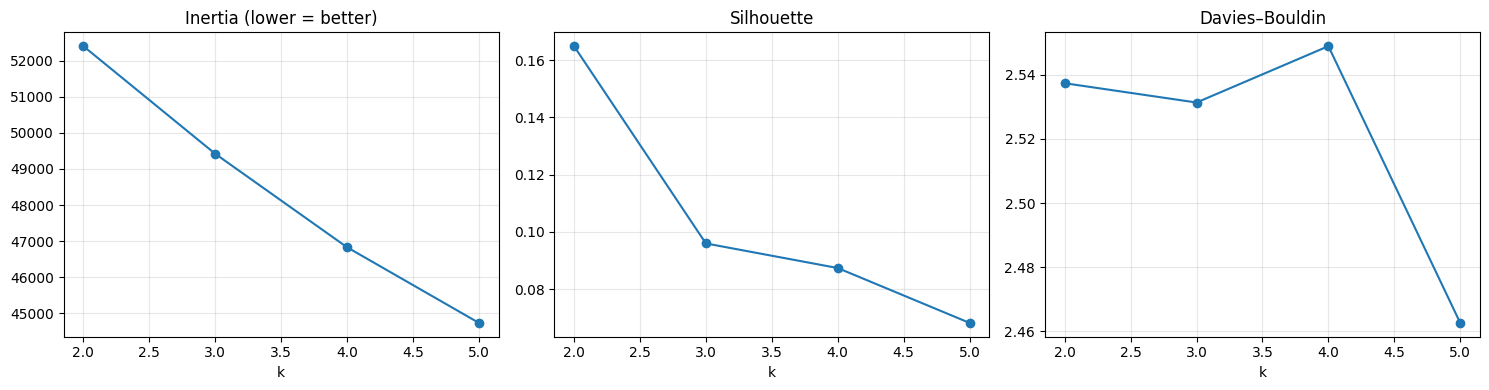

In [578]:
# Grid search over k to evaluate clustering metrics
k_candidates = range(2, 6)
rows = []
models = {}

for k_ in k_candidates:
    km = KMeans(
        n_clusters=k_,
        n_init=20,
        max_iter=500,
        random_state=42
    ).fit(fred_PCA_IS)

    # Basic metrics: within-cluster SSE (inertia)
    labels_tr = km.labels_
    inertia   = km.inertia_

    # Some metrics need n_samples > n_clusters
    if len(fred_PCA_IS) > k_:
        sil = silhouette_score(fred_PCA_IS, labels_tr)
        ch  = calinski_harabasz_score(fred_PCA_IS, labels_tr)
        db  = davies_bouldin_score(fred_PCA_IS, labels_tr)
    else:
        sil, ch, db = np.nan, np.nan, np.nan

    rows.append({
        "k": k_,
        "inertia": inertia,
        "silhouette": sil,
        "calinski_harabasz": ch,
        "davies_bouldin": db
    })

    # Store the fitted model for later use
    models[k_] = km

km_df = pd.DataFrame(rows).set_index("k")

# Plots to help choose k
fig, ax = plt.subplots(1, 3, figsize=(15,4))
ax[0].plot(km_df.index, km_df["inertia"], marker='o')
ax[0].set_title("Inertia (lower = better)")
ax[0].set_xlabel("k")
ax[0].grid(alpha=0.3)

ax[1].plot(km_df.index, km_df["silhouette"], marker='o')
ax[1].set_title("Silhouette")
ax[1].set_xlabel("k")
ax[1].grid(alpha=0.3)

ax[2].plot(km_df.index, km_df["davies_bouldin"], marker='o')
ax[2].set_title("Davies–Bouldin")
ax[2].set_xlabel("k")
ax[2].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# ---- Choice of k ----
chosen_k = 2
kmeans = models[chosen_k]

# Get labels for the chosen model
labels_tr = kmeans.labels_

# Convert labels to 1..k instead of 0..k-1 and attach time index
reg_kmeans_IS = pd.Series(
    labels_tr + 1,
    index=fred_PCA_IS.index,
    name="regime"
)


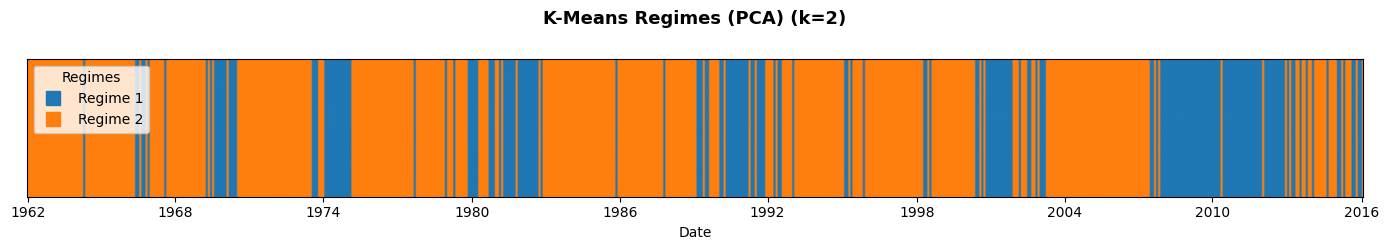

In [579]:
# Use one color per regime
n_regimes = chosen_k
palette = sns.color_palette("tab10", n_colors=n_regimes)
random.shuffle(palette)
cmap = ListedColormap(palette)

# 1D "image" of regimes: shape (1, T)
# subtract 1 so regimes 1..k map to color indices 0..k-1
Z = (reg_kmeans_IS.values - 1).reshape(1, -1)
dates = reg_kmeans_IS.index

plt.figure(figsize=(14, 2.6))

# Horizontal heatmap: time on x-axis, regimes as colors
plt.imshow(Z, aspect="auto", cmap=cmap)

# No y-axis ticks (just a color band)
plt.yticks([])

# X-axis ticks: ~10 evenly spaced years
n_ticks = 10
tick_positions = np.linspace(0, Z.shape[1] - 1, n_ticks).astype(int)
tick_labels = [dates[i].strftime("%Y") for i in tick_positions]

plt.xticks(ticks=tick_positions, labels=tick_labels)

# Clean title
plt.title(
    f"K-Means Regimes (PCA) (k={n_regimes})",
    fontsize=13,
    weight="bold",
    pad=25
)

plt.xlabel("Date")

# Legend: one colored square per regime
handles = [
    plt.Line2D(
        [0], [0],
        marker="s",
        linestyle="",
        color=palette[k-1],
        label=f"Regime {k}",
        markersize=10
    )
    for k in range(1, n_regimes + 1)
]

plt.legend(handles=handles, title="Regimes", loc="upper left")
plt.tight_layout()
plt.show()

In [580]:
def kmeans_quality(X, kmeans_model):
    """
    Compute quality metrics for a fitted KMeans model.
    Useful to compare several KMeans models across different datasets.
    """
    labels = kmeans_model.labels_

    metrics = {
        "inertia": kmeans_model.inertia_,                    
        "silhouette": silhouette_score(X, labels),           
        "calinski_harabasz": calinski_harabasz_score(X, labels),  
        "davies_bouldin": davies_bouldin_score(X, labels)   
    }

    return pd.Series(metrics, name="quality")

quality = kmeans_quality(fred_PCA_IS, kmeans)
print("\nQuality of selected K-Means model:")
print(quality)



Quality of selected K-Means model:
inertia              52399.554005
silhouette               0.164894
calinski_harabasz       82.304593
davies_bouldin           2.537377
Name: quality, dtype: float64


**K-means Quality (PCA, k = 2):**

The K-means model fitted on the 28 PCA components shows relatively weak clustering structure. The silhouette score remains low (0.165), indicating that observations are only slightly closer to their assigned cluster than to alternative clusters. This is consistent with the Davies–Bouldin index (2.54), which points to substantial overlap between the two clusters. The Calinski–Harabasz score (82.30) is also modest, suggesting limited between-cluster separation relative to within-cluster dispersion.
Overall, these metrics indicate that K-means struggles to uncover well-defined macroeconomic regimes in this PCA space, even with only two clusters. This reinforces the idea that distance-based methods may be less suitable than probabilistic clustering for this dataset, and that regime identification is better handled by GMM.

**Reduced Dataset – K-means**

We also estimate a K-means model on the reduced set of selected macroeconomic variables, allowing regime detection to be performed directly in the original economic feature space.


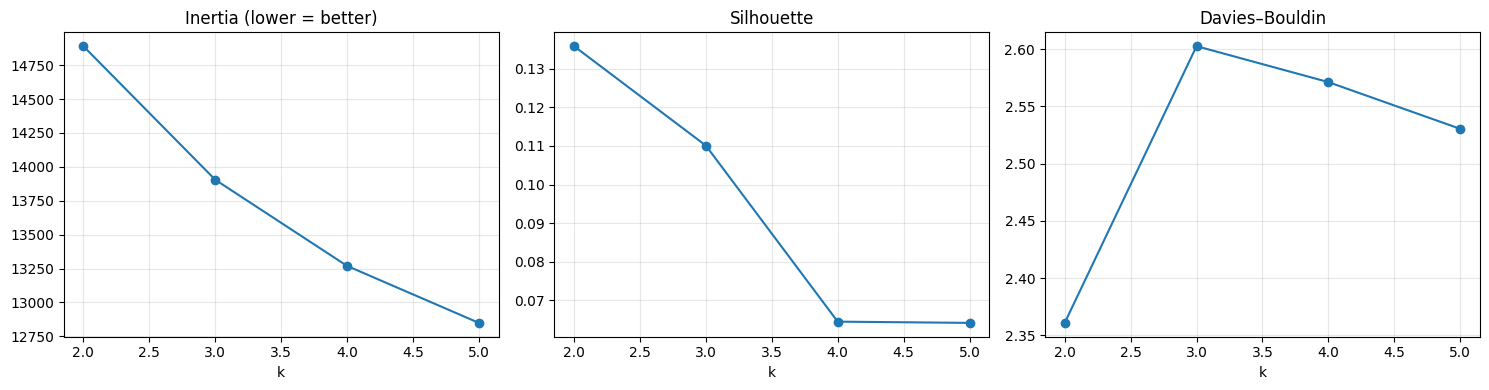

In [581]:
# Grid search over k to evaluate clustering metrics
k_candidates = range(2, 6)
rows = []
models = {}

for k_ in k_candidates:
    km = KMeans(
        n_clusters=k_,
        n_init=20,
        max_iter=500,
        random_state=42
    ).fit(fred_IS_bis)

    # Basic metrics: within-cluster SSE (inertia)
    labels_tr = km.labels_
    inertia   = km.inertia_

    # Some metrics need n_samples > n_clusters
    if len(fred_IS_bis) > k_:
        sil = silhouette_score(fred_IS_bis, labels_tr)
        ch  = calinski_harabasz_score(fred_IS_bis, labels_tr)
        db  = davies_bouldin_score(fred_IS_bis, labels_tr)
    else:
        sil, ch, db = np.nan, np.nan, np.nan

    rows.append({
        "k": k_,
        "inertia": inertia,
        "silhouette": sil,
        "calinski_harabasz": ch,
        "davies_bouldin": db
    })

    # Store the fitted model for later use
    models[k_] = km

km_df = pd.DataFrame(rows).set_index("k")

# Plots to help choose k
fig, ax = plt.subplots(1, 3, figsize=(15,4))
ax[0].plot(km_df.index, km_df["inertia"], marker='o')
ax[0].set_title("Inertia (lower = better)")
ax[0].set_xlabel("k")
ax[0].grid(alpha=0.3)

ax[1].plot(km_df.index, km_df["silhouette"], marker='o')
ax[1].set_title("Silhouette")
ax[1].set_xlabel("k")
ax[1].grid(alpha=0.3)

ax[2].plot(km_df.index, km_df["davies_bouldin"], marker='o')
ax[2].set_title("Davies–Bouldin")
ax[2].set_xlabel("k")
ax[2].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# ---- Choice of k ----
chosen_k = 2
kmeans_bis = models[chosen_k]

# Get labels for the chosen model
labels_tr_bis = kmeans_bis.labels_

# Convert labels to 1..k instead of 0..k-1 and attach time index
reg_kmeans_IS_bis = pd.Series(
    labels_tr_bis + 1,
    index=fred_IS_bis.index,
    name="regime"
)


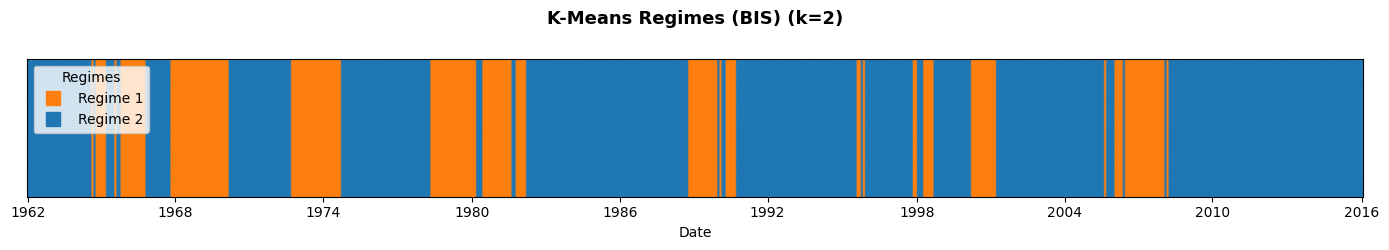

In [582]:
# Use one color per regime
n_regimes = chosen_k
palette = sns.color_palette("tab10", n_colors=n_regimes)
random.shuffle(palette)
cmap = ListedColormap(palette)

# 1D "image" of regimes: shape (1, T)
# subtract 1 so regimes 1..k map to color indices 0..k-1
Z = (reg_kmeans_IS_bis.values - 1).reshape(1, -1)
dates = reg_kmeans_IS_bis.index

plt.figure(figsize=(14, 2.6))

# Horizontal heatmap: time on x-axis, regimes as colors
plt.imshow(Z, aspect="auto", cmap=cmap)

# No y-axis ticks (just a color band)
plt.yticks([])

# X-axis ticks: ~10 evenly spaced years
n_ticks = 10
tick_positions = np.linspace(0, Z.shape[1] - 1, n_ticks).astype(int)
tick_labels = [dates[i].strftime("%Y") for i in tick_positions]

plt.xticks(ticks=tick_positions, labels=tick_labels)

# Clean title
plt.title(
    f"K-Means Regimes (BIS) (k={n_regimes})",
    fontsize=13,
    weight="bold",
    pad=25
)

plt.xlabel("Date")

# Legend: one colored square per regime
handles = [
    plt.Line2D(
        [0], [0],
        marker="s",
        linestyle="",
        color=palette[k-1],
        label=f"Regime {k}",
        markersize=10
    )
    for k in range(1, n_regimes + 1)
]

plt.legend(handles=handles, title="Regimes", loc="upper left")
plt.tight_layout()
plt.show()

In [583]:
quality = kmeans_quality(fred_IS_bis, kmeans_bis)
print("\nQuality of selected K-Means bis model:")
print(quality)


Quality of selected K-Means bis model:
inertia              14890.685422
silhouette               0.135852
calinski_harabasz       78.660492
davies_bouldin           2.360945
Name: quality, dtype: float64


**K-means Quality (Reduced Dataset, k = 2):** 

The K-means model fitted on the reduced macro-variable dataset also exhibits weak clustering structure. The silhouette score is low (0.136), implying that observations are only marginally closer to their assigned cluster than to the alternative one. This is consistent with the Davies–Bouldin index (2.36), which indicates substantial overlap between the two clusters. The Calinski–Harabasz score (78.66) is similarly modest, suggesting limited separation relative to within-cluster variance.

Overall, these results show that K-means struggles to extract clear macroeconomic regimes from the reduced variable set, performing similarly to the PCA-based specification. This further supports relying on probabilistic methods such as GMM, which provide sharper and more stable regime identification in this context.


In [584]:
def show_github_image(raw_url):
    from PIL import Image
    Image.MAX_IMAGE_PIXELS = None  

    response = requests.get(raw_url)
    img = Image.open(BytesIO(response.content))
    img.load() 

    plt.figure(figsize=(18, 6))
    plt.imshow(img)
    plt.axis("off")
    plt.show()

### Regime Detection conclusion

Across both the PCA representation and the reduced macro-variable dataset, the comparison between GMM and K-means shows a clear advantage for probabilistic clustering methods in identifying macroeconomic regimes. K-means, which relies solely on Euclidean distances and spherical clusters of equal variance, struggles to capture the complex distributional structure of macro data and tends to produce overlapping, weakly separated partitions. In contrast, even in its diagonal specification, GMM remains far more flexible: it estimates regime-specific variances, allows clusters to differ in scale across dimensions, and assigns observations probabilistically rather than deterministically. This enables the model to represent the heterogeneous volatility patterns that characterise macroeconomic states and to express uncertainty in a principled way through posterior regime probabilities. As a result, GMM produces sharper, more stable, and more interpretable regimes, making it a more appropriate tool for capturing the underlying macro structure and for supporting downstream prediction and portfolio applications.


For $𝑘=2$, the regime segmentation produces a clear and economically coherent split between periods of economic difficulty and periods of more stable conditions. The adverse regime appears precisely during major downturns, including the 1973–1975 recession, the double-dip recession around 1980–1982, and the 2008 financial crisis, all of which show up as persistent blocks of the “stress” state. Conversely, long stretches of economic expansion—such as the late 1980s, most of the 1990s, and the mid-2000s—are consistently classified in the “favorable” regime. These patterns are remarkably stable across the different model specifications (PCA, reduced dataset, GMM and K-means), all of which recover the same broad macroeconomic cycles. Overall, the two-regime specification captures the main turning points of the historical sample in a clean and intuitive way, providing a solid baseline for interpretation and forecasting.

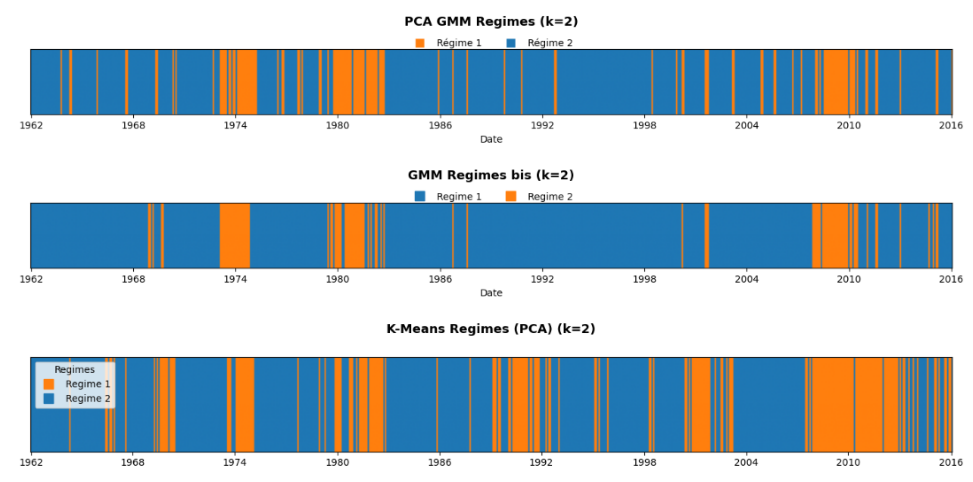

In [585]:
show_github_image("https://raw.githubusercontent.com/lxsd111/ML_PM/main/nbs/Cluster_IS.png")

Since the models with $𝑘=3$ detect essentially the same macro regimes (normal vs. crisis) as with $k=2$ , we do not retain $k=3$.

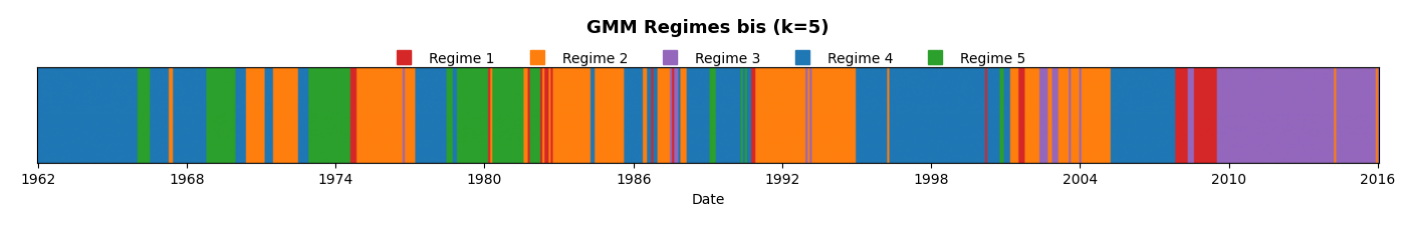

In [586]:
show_github_image("https://raw.githubusercontent.com/lxsd111/ML_PM/main/nbs/GMM_reg.png")

We now interpret the results obtained with the GMM-PCA model using $k=5$, noting that this specification produces clusters that are broadly consistent with those found across our other regime-detection models.

With $k=5$, the GMM no longer just separates “normal” versus “crisis” periods. It starts to distinguish different types of crises and policy environments:
- Green regime (Regime 5): 1970s and early 1980s oil-shock / inflation crises:
The green regime is concentrated around the two major macro crises of the 1970s and early 1980s (the 1973–74 and 1979–80 oil shocks). This regime likely corresponds to high and volatile inflation, sharp monetary tightening and large real-activity disruptions, i.e. supply-side/inflation crises.

- Red regime (Regime 1): 2008 global financial crisis:
The red regime appears around 2008, during the global financial crisis. Unlike the green regime, this episode is driven by a financial/banking shock and balance-sheet deleveraging, rather than an inflation shock. The model therefore separates the 1970s–80s crises from the 2008 crisis, even though they were previously grouped into a single “crisis” regime when using a smaller number of clusters.

- Purple regime (Regime 3): post-crisis low-interest-rate / QE environment:
The purple regime dominates in the post-2008 period, when policy rates are close to the zero lower bound and central banks implement large-scale asset purchases. This regime can be interpreted as a low-rate, high-liquidity environment with subdued inflation and unconventional monetary policy, distinct from both the pre-crisis “normal” expansions and the acute stress phase of 2008.

- Blue and orange regimes (Regimes 2 and 4): “normal” macro environments:
The remaining regimes (blue and orange) mainly cover the rest of the sample and can be seen as different flavours of “normal times” – for instance, periods of stronger growth versus slower growth or mild tightening phases – but without clear additional macro interpretation beyond what was already captured with a smaller number of regimes.

While these regimes exhibit clear and economically interpretable patterns, a recurring feature across all our models is that some clusters tend to be specific to particular historical periods. For instance, the ‘low-interest-rate’ regime (our purple state) consistently appears in every specification, yet only in the post-2008 environment. This suggests that certain clusters may capture structural changes in the economy rather than timeless macroeconomic states, which limits their generalisability for future regime identification.

This raises an important point for macro-regime clustering: models may identify states that are historically meaningful but not necessarily recurrent. When regimes are tied to unique events—such as the ZLB/QE period—they reflect long-term structural shifts rather than cyclical macro dynamics. Consequently, increasing the number of clusters can lead to regime definitions that are highly specific to one episode and therefore of limited value for forecasting or for building robust regime-dependent strategies.

Overall, these results highlight the trade-off inherent in macro-regime models. Richer specifications (larger k, flexible models like GMM) generate more nuanced and economically coherent states, but they risk overfitting the historical sample and producing regimes that are not stable across time. Simpler specifications (e.g. k =2) tend to capture more persistent and interpretable patterns—such as ‘normal’ versus ‘crisis’ phases—even if they miss some of the finer distinctions.

Although the $𝑘=2$ specification provides well-defined and economically intuitive regimes, it remains unclear whether such a simple two-state structure can genuinely predict upcoming crises, as major downturns are often driven by highly exogenous shocks—such as COVID-19—that lie outside the information set of standard macro variables.

## Predicting Market Regimes

Given these regime patterns, a natural next step is to assess whether such macroeconomic states can actually be predicted from our data. We therefore explore whether the information contained in our PCA factors (or reduced macro datasets) can be used to train a supervised model over 1960–2016 and evaluate its ability to classify regimes out-of-sample over 2016–2025. 

To do so, we focus on the simplest and most economically interpretable case: a two-regime specification (k = 2), typically separating “normal” periods from “crisis” states. We experiment with two types of inputs—PCA-transformed macro data and reduced macro variable sets—and several definitions of the regime labels, obtained either from GMM clustering or k-means clustering. Using these unsupervised labels as classification targets, we train a binary logistic regression on the 1960–2016 period, ensuring that normalization, PCA loadings, and all data transformations are computed strictly within the training window.

The fitted classifier is then applied to the out-of-sample period (2016–2025) to generate predicted regime probabilities and discrete regime labels. This framework allows us to assess, in a fully forward-looking setting, whether crisis regimes—identified ex post by our unsupervised models—display any degree of predictability from macroeconomic information alone, or whether such states remain driven by largely exogenous shocks that are inherently difficult to anticipate.

In [587]:
def fit_logit_regime_classifier(
    X_train,
    y_train,
    X_test,
    class_labels=(1, 2),
    class_weight=None, 
    C=1.0,
    penalty="l2",
    solver="lbfgs",
    random_state=None
):
    """
    Fit a binary logistic regression to predict regimes and apply it OOS.

    Parameters
    ----------
    X_train : pd.DataFrame
        In-sample features (e.g. PCA factors), indexed by date.
    y_train : pd.Series
        In-sample regime labels, must take exactly two values (e.g. 1 and 2).
    X_test : pd.DataFrame
        Out-of-sample features with the same columns as X_train.
    class_labels : tuple
        Tuple with the two regime labels in y_train, e.g. (1, 2).
        The first is treated as class 0, the second as class 1.
    C, penalty, solver, random_state :
        Passed to sklearn.linear_model.LogisticRegression.

    Returns
    -------
    results : dict
        {
          "model"         : fitted LogisticRegression,
          "proba_IS"      : Series of P(class_labels[1]) in-sample,
          "pred_IS_label" : Series of predicted labels (class_labels[0/1]) in-sample,
          "proba_OOS"     : Series of P(class_labels[1]) out-of-sample,
          "pred_OOS_label": Series of predicted labels out-of-sample
        }
    """

    # Ensure pandas objects
    X_train = pd.DataFrame(X_train)
    X_test  = pd.DataFrame(X_test)
    y_train = pd.Series(y_train)

    # Check labels
    uniq = set(y_train.unique())
    assert uniq <= set(class_labels), (
        f"y_train must contain only {class_labels}, got {uniq}."
    )

    # Binary encoding: class_labels[0] -> 0, class_labels[1] -> 1
    y_bin = (y_train == class_labels[1]).astype(int)

    # Fit logistic regression
    logit = LogisticRegression(
        penalty=penalty,
        C=C,
        solver=solver,
        random_state=random_state
    )
    logit.fit(X_train, y_bin)

    # -------- In-sample predictions --------
    proba_IS = pd.Series(
        logit.predict_proba(X_train)[:, 1],    # prob of class_labels[1]
        index=X_train.index,
        name=f"p_regime{class_labels[1]}_IS"
    )

    pred_IS_bin = pd.Series(
        logit.predict(X_train),                # 0/1
        index=X_train.index,
        name="regime_pred_IS_bin"
    )

    # Map back to original labels
    pred_IS_label = pd.Series(
        pred_IS_bin.map({0: class_labels[0], 1: class_labels[1]}),
        index=pred_IS_bin.index,
        name="regime_pred_IS"
    )

    # -------- Out-of-sample predictions --------
    # Make sure columns are aligned
    X_test = X_test[X_train.columns]

    proba_OOS = pd.Series(
        logit.predict_proba(X_test)[:, 1],
        index=X_test.index,
        name=f"p_regime{class_labels[1]}_OOS"
    )

    pred_OOS_bin = pd.Series(
        logit.predict(X_test),
        index=X_test.index,
        name="regime_pred_OOS_bin"
    )

    pred_OOS_label = pd.Series(
        pred_OOS_bin.map({0: class_labels[0], 1: class_labels[1]}),
        index=pred_OOS_bin.index,
        name="regime_pred_OOS"
    )

    return {
        "model": logit,
        "proba_IS": proba_IS,
        "pred_IS_label": pred_IS_label,
        "proba_OOS": proba_OOS,
        "pred_OOS_label": pred_OOS_label,
    }


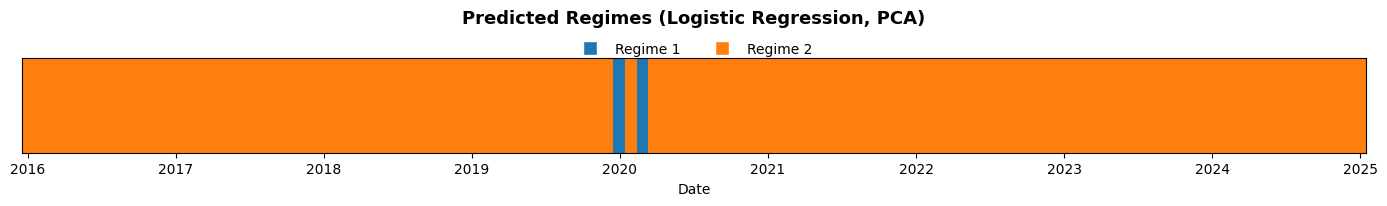

In [588]:
results = fit_logit_regime_classifier(
    X_train=fred_PCA_IS,
    y_train=reg_gmm_IS,     
    X_test=fred_PCA_OOS,
    class_labels=(1, 2),
    C=1.0,
    penalty="l2",
    solver="lbfgs",
     class_weight="balanced", 
    random_state=42
)

logit        = results["model"]
proba_IS     = results["proba_IS"]
regime_IS    = results["pred_IS_label"]
proba_OOS    = results["proba_OOS"]
regime_GMM_PCA_OOS   = results["pred_OOS_label"]


colors = {1: "royalblue", 2: "orange"}

reg = regime_GMM_PCA_OOS.dropna()
dates = reg.index
labels = reg.values
n_regimes = 2

# 0..K-1 for the colormap, but labels are 1..K
Z = (labels - 1).reshape(1, -1)

# --- Random color palette like in your GMM plot ---
palette = sns.color_palette("tab10", n_colors=n_regimes)
random.shuffle(palette)
cmap = ListedColormap(palette)

# --- Figure ---
plt.figure(figsize=(14, 2.6))

# Horizontal "heatmap" band
plt.imshow(Z, aspect="auto", cmap=cmap)
plt.yticks([])

# Time ticks: 10 evenly spaced years
plt.xticks(
    ticks=np.linspace(0, len(dates) - 1, 10),
    labels=pd.to_datetime(
        np.linspace(dates[0].value, dates[-1].value, 10)
    ).strftime("%Y")
)

# Title
plt.title(
    "Predicted Regimes (Logistic Regression, PCA)",
    fontsize=13,
    weight="bold",
    pad=25
)
plt.xlabel("Date")

# Legend: Regime 1..K with the right colors
handles = [
    plt.Line2D(
        [0], [0],
        marker="s",
        color="w",
        label=f"Regime {k}",
        markerfacecolor=palette[k - 1],
        markersize=10
    )
    for k in range(1, n_regimes + 1)
]

plt.legend(
    handles=handles,
    loc="upper center",
    bbox_to_anchor=(0.5, 1.30),
    ncol=n_regimes,
    frameon=False
)

plt.tight_layout(rect=[0, 0, 1, 0.85])
plt.show()

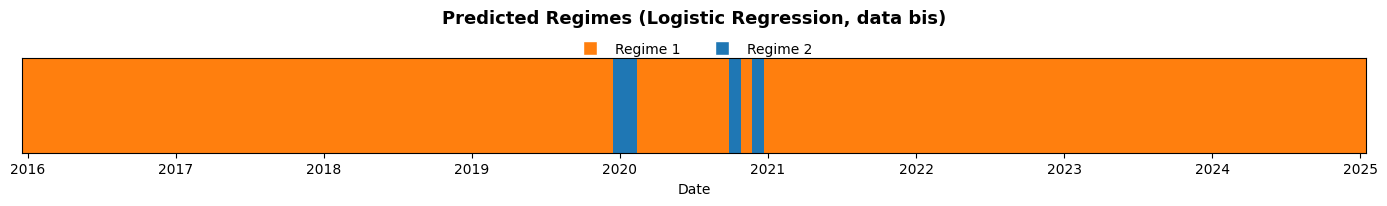

In [589]:
results = fit_logit_regime_classifier(
    X_train=fred_IS_bis,
    y_train=reg_gmm_IS_bis,     
    X_test=fred_OOS_bis,
    class_labels=(1, 2),
    C=1.0,
    penalty="l2",
    solver="lbfgs",
    random_state=42
)

logit        = results["model"]
proba_IS     = results["proba_IS"]
regime_IS    = results["pred_IS_label"]
proba_OOS    = results["proba_OOS"]
regime_GMM_bis_OOS   = results["pred_OOS_label"]


colors = {1: "royalblue", 2: "orange"}

reg = regime_GMM_bis_OOS.dropna()
dates = reg.index
labels = reg.values
n_regimes = 2

# 0..K-1 for the colormap, but labels are 1..K
Z = (labels - 1).reshape(1, -1)

# --- Random color palette like in your GMM plot ---
palette = sns.color_palette("tab10", n_colors=n_regimes)
random.shuffle(palette)
cmap = ListedColormap(palette)

# --- Figure ---
plt.figure(figsize=(14, 2.6))

# Horizontal "heatmap" band
plt.imshow(Z, aspect="auto", cmap=cmap)
plt.yticks([])

# Time ticks: 10 evenly spaced years
plt.xticks(
    ticks=np.linspace(0, len(dates) - 1, 10),
    labels=pd.to_datetime(
        np.linspace(dates[0].value, dates[-1].value, 10)
    ).strftime("%Y")
)

# Title
plt.title(
    "Predicted Regimes (Logistic Regression, data bis)",
    fontsize=13,
    weight="bold",
    pad=25
)
plt.xlabel("Date")

# Legend: Regime 1..K with the right colors
handles = [
    plt.Line2D(
        [0], [0],
        marker="s",
        color="w",
        label=f"Regime {k}",
        markerfacecolor=palette[k - 1],
        markersize=10
    )
    for k in range(1, n_regimes + 1)
]

plt.legend(
    handles=handles,
    loc="upper center",
    bbox_to_anchor=(0.5, 1.30),
    ncol=n_regimes,
    frameon=False
)

plt.tight_layout(rect=[0, 0, 1, 0.85])
plt.show()



c:\Users\user\anaconda3\envs\anto\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


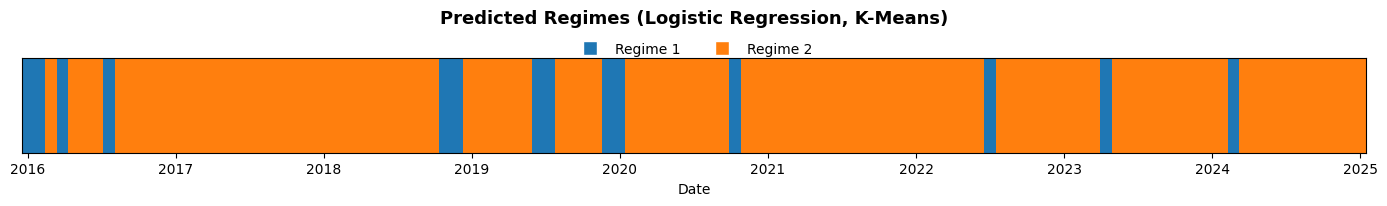

In [590]:
results = fit_logit_regime_classifier(
    X_train=fred_IS,
    y_train=reg_kmeans_IS,     
    X_test=fred_OOS,
    class_labels=(1, 2),
    C=1.0,
    penalty="l2",
    solver="lbfgs",
    random_state=42
)

logit        = results["model"]
proba_IS     = results["proba_IS"]
regime_IS    = results["pred_IS_label"]
proba_OOS    = results["proba_OOS"]
regime_kmeans_OOS   = results["pred_OOS_label"]


colors = {1: "royalblue", 2: "orange"}

reg = regime_kmeans_OOS.dropna()
dates = reg.index
labels = reg.values
n_regimes = 2

# 0..K-1 for the colormap, but labels are 1..K
Z = (labels - 1).reshape(1, -1)

# --- Random color palette like in your GMM plot ---
palette = sns.color_palette("tab10", n_colors=n_regimes)
random.shuffle(palette)
cmap = ListedColormap(palette)

# --- Figure ---
plt.figure(figsize=(14, 2.6))

# Horizontal "heatmap" band
plt.imshow(Z, aspect="auto", cmap=cmap)
plt.yticks([])

# Time ticks: 10 evenly spaced years
plt.xticks(
    ticks=np.linspace(0, len(dates) - 1, 10),
    labels=pd.to_datetime(
        np.linspace(dates[0].value, dates[-1].value, 10)
    ).strftime("%Y")
)

# Title
plt.title(
    "Predicted Regimes (Logistic Regression, K-Means)",
    fontsize=13,
    weight="bold",
    pad=25
)
plt.xlabel("Date")

# Legend: Regime 1..K with the right colors
handles = [
    plt.Line2D(
        [0], [0],
        marker="s",
        color="w",
        label=f"Regime {k}",
        markerfacecolor=palette[k - 1],
        markersize=10
    )
    for k in range(1, n_regimes + 1)
]

plt.legend(
    handles=handles,
    loc="upper center",
    bbox_to_anchor=(0.5, 1.30),
    ncol=n_regimes,
    frameon=False
)

plt.tight_layout(rect=[0, 0, 1, 0.85])
plt.show()



The three first panels show the out-of-sample regime predictions (2016–2025) from logistic regressions trained on 1960–2016. The models differ only in how regimes and inputs were constructed: the first uses K-Means, the second a reduced macro dataset on GMM, and the third PCA factors on GMM. Each plot displays how the classifier assigns Regime 1 vs. Regime 2 under these three setups.

The K-Means–based classifier produces many short switches between regimes, suggesting that the underlying K-Means labels capture local fluctuations rather than persistent macroeconomic states. In contrast, the reduced dataset and PCA setups yield much more stable predictions: both models classify almost the entire 2016–2025 period as a normal regime, except for a clear and consistent spike into the “crisis” regime around 2020. This aligns well with the COVID-19 macro shock, indicating that these representations contain enough information to detect major disruptions while avoiding false positives.

The last panel is not a prediction: it is simply a GMM clustering with $k=3$ run on the full 2016–2025 PCA dataset, plotted only from 2016 onward and used solely as a benchmark to compare against our logistic-regression forecasts.

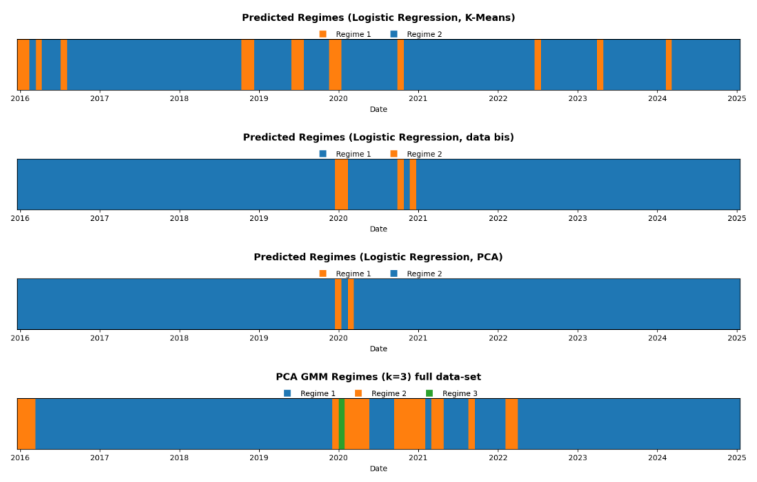

In [591]:
show_github_image("https://raw.githubusercontent.com/lxsd111/ML_PM/main/nbs/CLuster_full.png")

Even though these regime patterns are economically meaningful, it remains unclear whether the model is truly predicting crises or simply fitting them once they have already materialized. To assess whether these regime signals carry any real forecasting value, we next test a simple portfolio strategy that uses the predicted regimes as inputs.

## Portfolio Implementation

For the portfolio-construction stage, we use the macroeconomic regimes identified by our unsupervised pipeline to condition all return forecasts. After estimating the regimes on the training sample, we compute for each regime the empirical moments of factor and industry returns — that is, the conditional means and covariances $E[r∣regime]$ and $Cov(𝑟∣regime)$. During the test period, our supervised model predicts a regime at each date, and we map these predicted regimes to the corresponding conditional moments. In other words, expected returns in the test sample are obtained directly from the historical moments associated with the predicted macroeconomic regime.

Using these regime-conditioned forecasts, we then build Markowitz portfolios based on the predicted means and covariances. The optimization is performed in a standard mean–variance framework, maximizing the risk-adjusted expected return under conventional constraints. Finally, we compare the performance of these regime-aware portfolios to a simple equal-weight benchmark, allowing us to assess whether incorporating predicted macroeconomic regimes improves out-of-sample portfolio allocation.

We start all portfolio-construction exercises in July 1963, which corresponds to the earliest availability of the factor return data.

In [592]:
indus_IS = indus_IS.loc["1963-07-01":].copy()
factors_IS = factors_IS.loc["1963-07-01":].copy()
reg_gmm_IS = reg_gmm_IS.loc["1963-07-01":].copy()
reg_gmm_IS_bis = reg_gmm_IS_bis.loc["1963-07-01":].copy()
reg_kmeans_IS = reg_kmeans_IS.loc["1963-07-01":].copy()
reg_kmeans_IS_bis = reg_kmeans_IS_bis.loc["1963-07-01":].copy()

### Conditional Moments Estimation

In [593]:
def conditional_moments(
    returns_df: pd.DataFrame,
    regimes_df: pd.DataFrame,
    label_col: str = "label",
    cols: list[str] | None = None,
    min_obs: int = 12,
) -> tuple[pd.DataFrame, pd.DataFrame, dict[int, pd.DataFrame], pd.Series]:
    """
    Compute conditional means, standard deviations, and covariances E[R | regime]
    with robust date alignment between return data and regime labels.
    """

    # Align both datasets on the intersection of dates, starting at the most recent common date
    r0, g0 = returns_df.sort_index(), regimes_df.sort_index()
    start = max(r0.index.min(), g0.index.min())
    r1 = r0.loc[start:]
    g1 = g0.loc[start:]
    df = r1.join(g1[[label_col]], how="inner").dropna(subset=[label_col])

    # Select the return columns to use (numeric columns by default)
    if cols is None:
        cols = df.select_dtypes(include=[np.number]).columns.drop(label_col, errors="ignore")
    else:
        cols = pd.Index(cols).intersection(df.columns)

    # Compute conditional moments for each regime, keeping only regimes with enough observations
    groups = dict(tuple(df.groupby(label_col)))
    means, stds, covs, counts = {}, {}, {}, {}
    for reg, sub in groups.items():
        subX = sub[cols].dropna(how="any")
        n = len(subX)
        if n >= min_obs:
            means[reg] = subX.mean()
            stds[reg]  = subX.std(ddof=1)
            covs[reg]  = subX.cov()
            counts[reg]= n

    # Assemble output tables
    mean_df = pd.DataFrame(means).T.sort_index()
    std_df  = pd.DataFrame(stds).T.sort_index()
    n_by_regime = pd.Series(counts).sort_index()

    return mean_df, std_df, covs, n_by_regime


In [594]:
# Compute conditional moments using in-sample estimated regimes 
mean_ind_IS, std_ind_IS, cov_ind_IS, n_ind_IS = conditional_moments(
    returns_df = indus_IS,      # raw industry returns
    regimes_df = reg_gmm_IS.to_frame(name="label"),
    label_col  = "label",
    min_obs    = 12
)

We compute the conditional returns of the factors using the regimes estimated by the GMM model, but the resulting moments—and the portfolio performances obtained from them—are very similar when using the alternative GMM-bis specification or the K-means clustering. This indicates that our conclusions are robust to the choice of regime-classification method.

In [595]:
# Compute conditional moments using in-sample estimated regimes
mean_fac_IS, std_fac_IS, cov_fac_IS, n_fac_IS = conditional_moments(
    returns_df = factors_IS,     # raw factor returns
    regimes_df = reg_gmm_IS.to_frame(name="label"),
    label_col  = "label",
    min_obs    = 12
)

# Display results
print("=== Conditional means by regime ===")
print(mean_fac_IS.round(4))

print("\n=== Number of observations per regime ===")
print(n_fac_IS)

=== Conditional means by regime ===
      SMB     HML     RMW     CMA     MOM
1  0.0047  0.0028 -0.0010  0.0052 -0.0009
2  0.0018  0.0037  0.0035  0.0024  0.0091

=== Number of observations per regime ===
1    131
2    500
dtype: int64


The factors we use are standard equity style factors, each proxied by the return of a long–short portfolio built on a specific characteristic. **SMB** (Small Minus Big) captures the size effect by going long small-cap stocks and short large caps. **HML** (High Minus Low) is the value factor, long high book-to-market (“value”) stocks and short low book-to-market (“growth”) stocks. **RMW** (Robust Minus Weak) measures profitability, long firms with robust operating profitability and short weak ones. **CMA** (Conservative Minus Aggressive) captures the investment effect, long low-investment firms and short high-investment firms. **MOM** is a momentum factor, typically long recent past winners and short recent past losers. The numbers in the table are average monthly returns of these long–short portfolios, conditional on the macro regime.

Based on the conditional means and the number of observations, **Regime 2** looks like the “normal/benign” macro environment: it is much more frequent (500 observations vs. 131) and all factor premia are positive, often quite strongly so. **Regime 1** is better interpreted as a “stress or difficult” regime, where some factors earn positive premia but others turn negative, suggesting phases of factor underperformance or factor rotations typically associated with crisis or transition periods.

Looking factor by factor, the patterns are quite telling. In the difficult Regime 1, SMB and CMA display relatively strong positive premia (around 0.5% per month), indicating that size and investment-based strategies can still be rewarded even in stressed environments. HML also remains modestly positive, so value does not collapse. By contrast, RMW and MOM are slightly negative in this regime, which is consistent with episodes where quality and momentum trades are unwound or suffer drawdowns. In the benign Regime 2, premia are broad-based: HML, RMW and especially MOM become clearly positive, with momentum delivering the highest average return (close to 1% per month), and size and investment also remaining positive, though at lower levels than in Regime 1. Overall, factor returns are not only different in level across regimes, but also in composition: crises tend to penalize profitability and momentum styles, while normal times are characterized by more uniform and stronger compensation across all factors.


### Portfolio construction

In [596]:
def predicted_moments_from_regimes(
    regimes_pred: pd.Series,
    mean_IS: pd.DataFrame,
    std_IS: pd.DataFrame | None = None,
    cov_IS: dict[int, pd.DataFrame] | None = None,
) -> tuple[pd.DataFrame, pd.DataFrame | None, dict | None]:
    """
    For each out-of-sample date, select the in-sample conditional moments
    (mean, std, covariance) corresponding to the predicted regime.

    Parameters
    ----------
    regimes_pred : pd.Series
        Predicted regimes (integers 0..K-1 or 1..K), indexed by date.
    mean_IS : pd.DataFrame
        Conditional means E[R|r] estimated in-sample
        (index = regimes, columns = assets/factors).
    std_IS : pd.DataFrame, optional
        Conditional standard deviations Std[R|r], same structure as mean_IS.
    cov_IS : dict[int -> DataFrame], optional
        Conditional covariance matrices Σ_r for each regime.

    Returns
    -------
    mu_pred  : DataFrame
        Predicted conditional mean for each date (dates × assets).
    std_pred : DataFrame or None
        Predicted conditional std for each date, if std_IS is provided.
    cov_pred : dict[Timestamp -> DataFrame] or None
        Predicted covariance matrix for each date, if cov_IS is provided.
    """

    # Ensure we are working with a clean Series of integers
    if isinstance(regimes_pred, pd.DataFrame):
        regimes_pred = regimes_pred.iloc[:, 0]
    regimes_pred = regimes_pred.astype(int)
    dates = pd.to_datetime(regimes_pred.index)

    cols = list(mean_IS.columns)

    # Select conditional means regime-by-regime
    mu_rows = [
        mean_IS.loc[k].values if k in mean_IS.index else np.zeros(len(cols))
        for k in regimes_pred.values
    ]
    mu_pred = pd.DataFrame(mu_rows, index=dates, columns=cols)

    # Select conditional stds (if provided)
    std_pred = None
    if std_IS is not None:
        std_rows = [
            std_IS.loc[k].values if k in std_IS.index else np.zeros(len(cols))
            for k in regimes_pred.values
        ]
        std_pred = pd.DataFrame(std_rows, index=dates, columns=cols)

    # Select conditional covariances (if provided)
    cov_pred = None
    if cov_IS is not None:
        cov_pred = {}
        for d, k in zip(dates, regimes_pred.values):
            if k in cov_IS:
                cov_pred[d] = cov_IS[k].copy()
            else:
                cov_pred[d] = pd.DataFrame(
                    np.zeros((len(cols), len(cols))), index=cols, columns=cols
                )

    return mu_pred, std_pred, cov_pred

**Forecasting Conditional Moments Using Predicted Regimes:**


In [597]:
mu_ind_pred_PCA, std_ind_pred_PCA, cov_ind_pred_PCA = predicted_moments_from_regimes(
    regimes_pred = regime_kmeans_OOS,   # regime_GMM_PCA_OOS, regime_GMM_bis_OOS, regime_kmeans_OOS
    mean_IS      = mean_ind_IS,
    std_IS       = std_ind_IS,
    cov_IS       = cov_ind_IS
)

mu_fac_pred_PCA, std_fac_pred_PCA, cov_fac_pred_PCA = predicted_moments_from_regimes(
    regimes_pred = regime_kmeans_OOS,
    mean_IS      = mean_fac_IS,
    std_IS       = std_fac_IS,
    cov_IS       = cov_fac_IS
)

This code takes the expected returns and covariances predicted by the regime model and uses them to build a tangency (maximum Sharpe) portfolio at each date. It then computes the corresponding out-of-sample portfolio returns by applying the weights from time t to realized returns at time t + 1.

In [598]:
# --- Markowitz building blocks (tangency only) ---
def tangency_portfolio(mu: pd.Series, cov: pd.DataFrame, rf: float = 0.0) -> pd.Series:
    """
    Builds the tangency (maximum Sharpe ratio) portfolio under the constraint
    that all weights sum to 1. The portfolio is obtained by applying the 
    inverse of the covariance matrix to the vector of expected excess returns,
    then normalizing the result so that the weights add up to one.
    """
    inv = np.linalg.pinv(cov.values)  # pseudo-inverse for numerical stability
    excess = mu.values - rf
    w = inv @ excess
    s = w.sum()
    w = w / s if s != 0 else w
    return pd.Series(w, index=mu.index)


def weights_from_predicted_moments(
    mu_pred: pd.DataFrame,                     # predicted expected returns at each date
    cov_pred: dict | None = None,             # predicted covariance matrices (optional)
    rf: float = 0.0,                           # risk-free rate for tangency portfolios
    cov_fallback: pd.DataFrame | None = None, # used if no covariance is provided
    rebalance_horizon: int = 1                # number of periods between rebalancings
) -> pd.DataFrame:
    """
    Computes tangency portfolio weights at each date using the predicted 
    expected returns and, when available, the corresponding predicted 
    covariance matrix. If no covariance is provided, a fallback matrix is used.

    The parameter `rebalance_horizon` controls how often weights are updated.
    For example, with monthly data and rebalance_horizon=2, weights are
    recomputed every two months and kept constant in between.
    """
    mu_pred = mu_pred.copy()
    mu_pred.index = pd.to_datetime(mu_pred.index)
    cols = list(mu_pred.columns)

    W_list = []
    last_w = None

    for i, (dt, mu_row) in enumerate(mu_pred.iterrows()):
        # Only recompute weights every `rebalance_horizon` periods
        if i % rebalance_horizon == 0 or last_w is None:
            # Select the covariance matrix for the given date
            if cov_pred is not None and dt in cov_pred:
                C = cov_pred[dt].reindex(index=cols, columns=cols)
            elif cov_fallback is not None:
                C = cov_fallback.reindex(index=cols, columns=cols)
            else:
                # If nothing is available, use an identity matrix
                C = pd.DataFrame(np.eye(len(cols)), index=cols, columns=cols)

            # Compute the tangency portfolio for that date
            w_t = tangency_portfolio(mu_row.astype(float), C.astype(float)).reindex(cols).fillna(0.0)
            last_w = w_t
        else:
            # Keep previous weights if we are between rebalancing dates
            w_t = last_w

        W_list.append(w_t)

    W = pd.DataFrame(W_list, index=mu_pred.index, columns=cols)
    return W



def portfolio_returns_from_weights(
    weights: pd.DataFrame,          
    realized_returns: pd.DataFrame, 
    shift_horizon: int = 1
) -> pd.Series:
    """
    Computes portfolio returns by applying the weights of date t to the 
    realized returns of date t + shift_horizon. This prevents look-ahead bias.
    """
    W = weights.copy();   W.index = pd.to_datetime(W.index)
    R = realized_returns.copy(); R.index = pd.to_datetime(R.index)

    # Keep overlapping dates and common assets
    common_idx = W.index.intersection(R.index)
    common_cols = W.columns.intersection(R.columns)
    W = W.loc[common_idx, common_cols]
    R = R.loc[common_idx, common_cols]

    # Apply w(t) to R(t + shift_horizon)
    port = (W.shift(shift_horizon) * R).sum(axis=1).dropna()
    return port


We compare the out-of-sample performance of two factor portfolios: an equal-weight benchmark and a regime-based Markowitz portfolio. The Markowitz weights are constructed from the expected returns and covariances predicted by the macro regime model, while the benchmark simply assigns the same weight to each factor.

Tangency (factors) — Annualized mean   = 0.0143
Tangency (factors) — Annualized vol    = 0.0442
Tangency (factors) — Annualized Sharpe = 0.32
Equal-weight (factors) — Annualized mean   = 0.0018
Equal-weight (factors) — Annualized vol    = 0.0487
Equal-weight (factors) — Annualized Sharpe = 0.04


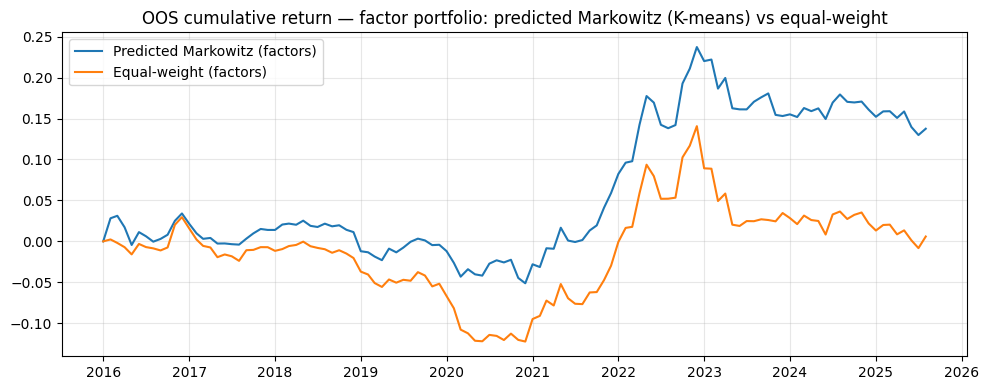

In [599]:
# Build an equal-weight portfolio at each date, using the same factor set as in factors_OOS
n_factors = factors_OOS.shape[1]
w_fac_eq = pd.DataFrame(
    np.ones((len(factors_OOS), n_factors)) / n_factors,
    index=factors_OOS.index,
    columns=factors_OOS.columns
)

# Out-of-sample equal-weight portfolio returns:
# the weights from date t are applied to the realized returns at date t+1
r_fac_eq_oos = portfolio_returns_from_weights(
    weights          = w_fac_eq,
    realized_returns = factors_OOS,
    shift_horizon    = 1
)

# Predicted tangency weights obtained from the regime-based expected returns
# and predicted covariance matrices (if provided)
W_fac_oos = weights_from_predicted_moments(
    mu_pred      = mu_fac_pred_PCA,
    cov_pred     = cov_fac_pred_PCA,
    rf           = 0.0,
    cov_fallback = None
)

# Out-of-sample Markowitz portfolio returns, applying weights at t to returns at t+1  
r_fac_oos = portfolio_returns_from_weights(
    weights          = W_fac_oos,
    realized_returns = factors_OOS,
    shift_horizon    = 1
)

# Compute basic performance metrics using annualized mean return,
# annualized volatility, and annualized Sharpe ratio
ann = 12  # monthly data → annualization factor

mean_fac_oos = r_fac_oos.mean()
vol_fac_oos  = r_fac_oos.std(ddof=1)
sharpe_fac   = (mean_fac_oos * ann) / (vol_fac_oos * np.sqrt(ann)) if vol_fac_oos > 0 else np.nan

mean_fac_eq = r_fac_eq_oos.mean()
vol_fac_eq  = r_fac_eq_oos.std(ddof=1)
sharpe_fac_eq = (mean_fac_eq * ann) / (vol_fac_eq * np.sqrt(ann)) if vol_fac_eq > 0 else np.nan

print(f"Tangency (factors) — Annualized mean   = {mean_fac_oos * ann:.4f}")
print(f"Tangency (factors) — Annualized vol    = {vol_fac_oos * np.sqrt(ann):.4f}")
print(f"Tangency (factors) — Annualized Sharpe = {sharpe_fac:.2f}")

print(f"Equal-weight (factors) — Annualized mean   = {mean_fac_eq * ann:.4f}")
print(f"Equal-weight (factors) — Annualized vol    = {vol_fac_eq * np.sqrt(ann):.4f}")
print(f"Equal-weight (factors) — Annualized Sharpe = {sharpe_fac_eq:.2f}")

# Plot cumulative out-of-sample returns for both the predicted Markowitz portfolio
# and the equal-weight benchmark
plt.figure(figsize=(10, 4))
plt.plot((1 + r_fac_oos).cumprod() - 1,   label="Predicted Markowitz (factors)")
plt.plot((1 + r_fac_eq_oos).cumprod() - 1, label="Equal-weight (factors)")
plt.title("OOS cumulative return — factor portfolio: predicted Markowitz (K-means) vs equal-weight")
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


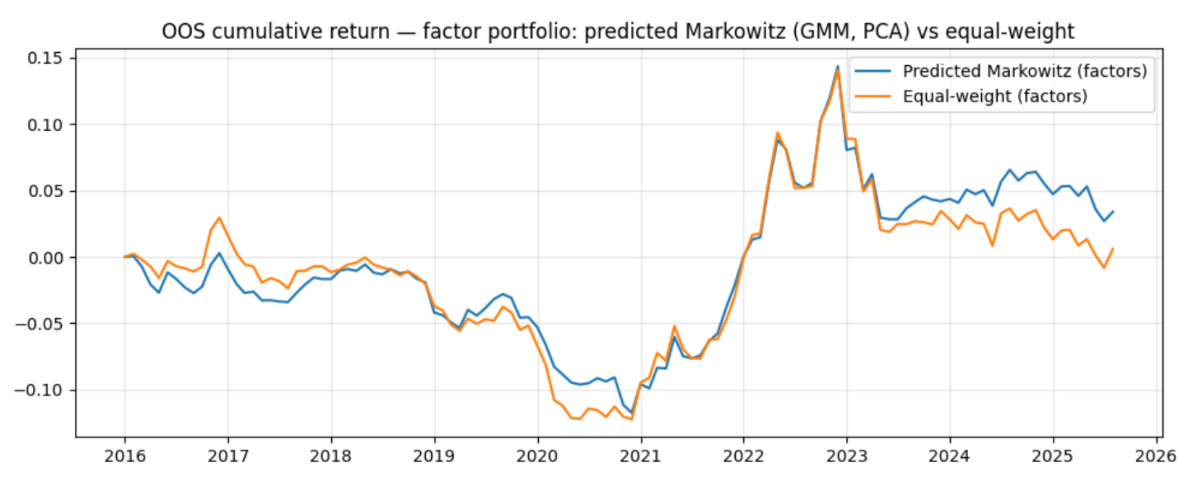

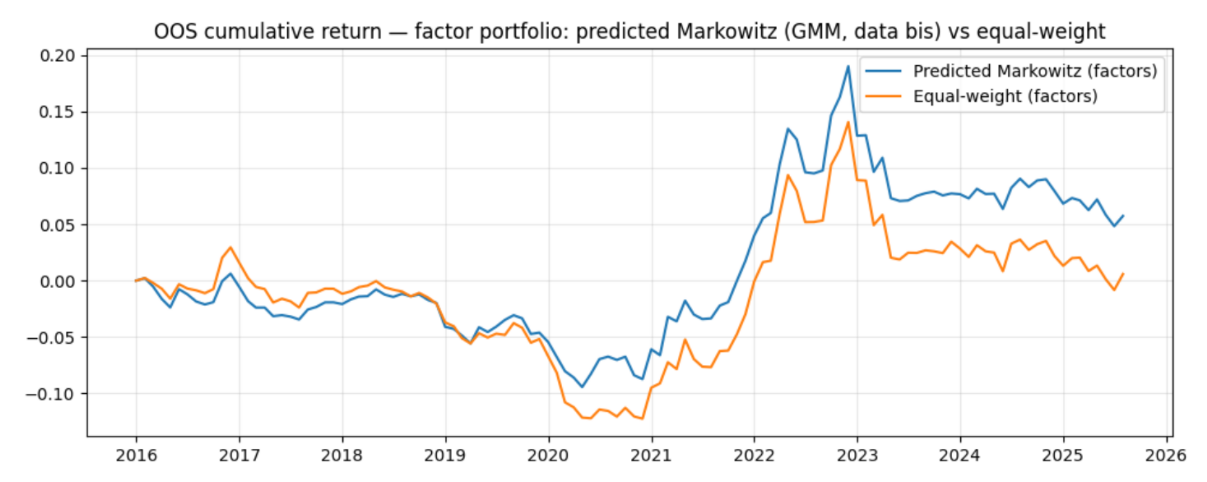

In [600]:
show_github_image("https://raw.githubusercontent.com/lxsd111/ML_PM/main/nbs/rend_f1.png")
show_github_image("https://raw.githubusercontent.com/lxsd111/ML_PM/main/nbs/rend_f2.png")

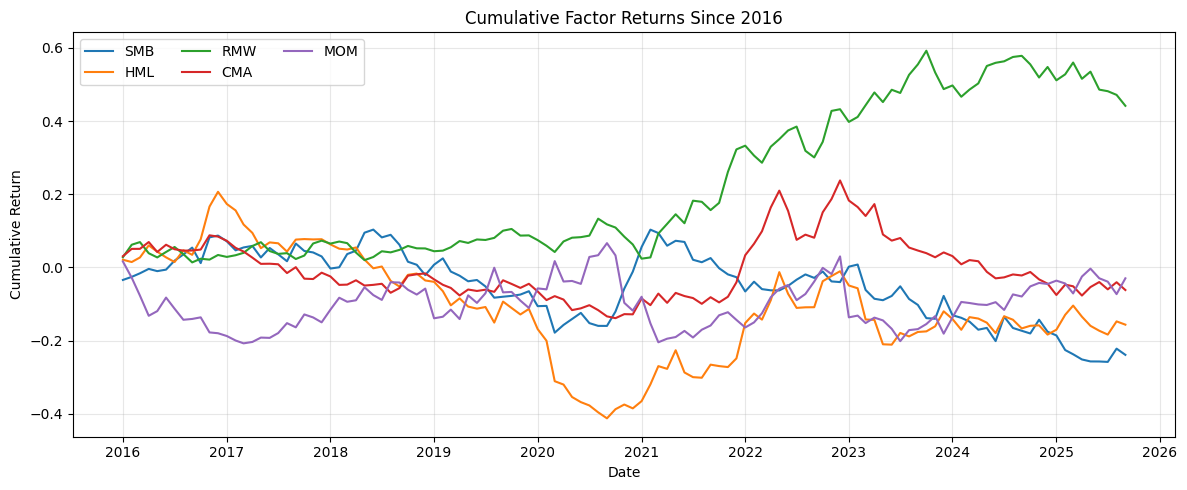

In [601]:
# Select data starting in 2016
factors_2016 = factors.loc["2016":].copy()

# Compute cumulative returns (cumprod for returns, cumsum if you want simple cumulative sum)
cum_factors = (1 + factors_2016).cumprod() - 1

# Plot
plt.figure(figsize=(12, 5))
plt.plot(cum_factors)
plt.title("Cumulative Factor Returns Since 2016")
plt.xlabel("Date")
plt.ylabel("Cumulative Return")
plt.grid(alpha=0.3)
plt.legend(cum_factors.columns, ncol=3)
plt.tight_layout()
plt.show()


In terms of factor-portfolio performance, we find that the results are remarkably robust across modelling choices. Whether the logistic regression is trained on regimes obtained from K-means, GMM, or our alternative GMM-bis specification, and whether we rebalance the portfolio monthly or at lower frequencies, the regime-aware Markowitz strategy outperforms the equal-weight benchmark in almost all configurations. This indicates that the added value of conditioning on predicted regimes is not sensitive to the specific clustering method or to the rebalancing horizon. However, these results should be interpreted with some caution, as we do not account for transaction costs, which would mechanically reduce the realised performance of high-turnover strategies.

Overall, the regime-based Markowitz portfolios consistently outperform the equal-weight benchmark across models, rebalancing frequencies, and clustering specifications. A key question, however, is whether this outperformance reflects genuine predictive power or simply the model’s ability to correctly identify the prevailing macroeconomic regime. Our framework does not allow us to fully disentangle these two mechanisms, and both likely contribute to the final result. Still, even when the model is primarily “recognising” the current environment rather than forecasting regime shifts ahead of time, this information already proves valuable: once the regime is identified, the conditional factor moments give clear guidance on how to rotate between pro-cyclical and defensive styles.

In that sense, the value of our methodology does not primarily come from prediction, but from the way it connects macroeconomic regimes to the conditional behaviour of asset-pricing factors. The unsupervised step identifies economically meaningful regimes, and the supervised step allows us to assign each new observation to one of these regimes in real time. Once the regime is known, the historical factor moments conditioned on that regime provide a coherent and intuitive guide for rotating between defensive and pro-cyclical exposures. Even if forecasting power is limited, simply understanding the current macro regime and exploiting its associated conditional moments leads to systematic and economically meaningful improvements over a naïve equal-weight allocation.

Our analysis shows that macroeconomic regimes extracted from high-dimensional data can be meaningfully linked to the conditional behaviour of asset-pricing factors. Across a wide range of specifications—different clustering methods (K-means, GMM, GMM-bis), different regime counts, and different rebalancing frequencies—the regime-aware Markowitz strategy consistently outperforms a naïve equal-weight benchmark. This robustness suggests that the relationship between macro regimes and factor premia is not an artefact of a particular modelling choice, but rather reflects a genuine and persistent economic structure.

## Appendix



**Incorrect temporal train/test separation**  
This source of look-ahead bias occurs when the model is trained on data points that would not have been available at the time predictions are supposed to be made. For example, if a dataset is randomly shuffled before splitting, future observations can accidentally enter the training set for earlier predictions. Another typical case is when hyperparameters are tuned using information spanning the entire dataset, meaning that the model indirectly “sees” the future during optimization.

**Preprocessing that uses future information**  
This happens when transformations such as scaling, normalization, dimensionality reduction, or quantile computation are fitted on the full dataset instead of only on past information. For instance, calculating the global mean and standard deviation before splitting allows future values to influence the transformation applied to earlier samples, giving the model an unrealistic advantage. Similarly, computing global bins for discretization or performing PCA on the entire dataset creates features that implicitly embed information from observations that occur later in time.

**Feature engineering that incorporates future observations**  
Feature leakage arises when features are built using windows or statistics that include future samples. A common situation is the use of centered rolling windows, which blend past and future values into a single feature even though the future part would not have been known at prediction time. Another example occurs when summary statistics such as future maxima, future averages, or future trends are computed and mistakenly treated as features available at the current timestamp.

**Misalignment between features and labels**  
Look-ahead bias also emerges when the temporal alignment between features and labels is off by one or more steps. This often comes from subtle indexing mistakes where the feature at time *t+1* is accidentally paired with the label at time *t*. Such misalignment can also occur when constructing rolling windows where the last element of the window unintentionally includes a future observation, causing the model to rely on information that it should not have access to.

**Using revised, corrected, or future-derived data**  
Some datasets evolve over time due to updates, corrections, revisions, or restatements, and using the fully corrected dataset in retrospect can create hidden leakage. For example, if missing values are filled using global information, or if anomalies are detected and treated using statistics computed over the full dataset, then early samples end up depending on information that involves later observations. This type of look-ahead bias is subtle because it can occur even when the temporal split is done correctly, but the data itself implicitly contains future knowledge. Another frequent issue comes from values associated with a specific timestamp, which have been published days, weeks, or even months after that timestamp. 

**Evaluation procedures that allow future information to influence model design**  
Look-ahead bias can also result from evaluation methodologies that unintentionally let future outcomes affect earlier decisions. A typical example is performing model selection or feature selection using the full time span, which means that performance metrics computed on future samples guide choices applied to past samples. Another example occurs when cross-validation folds are created without respecting temporal order, causing the model to be exposed to patterns that only appear later in the sequence and therefore overstating its true predictive performance.


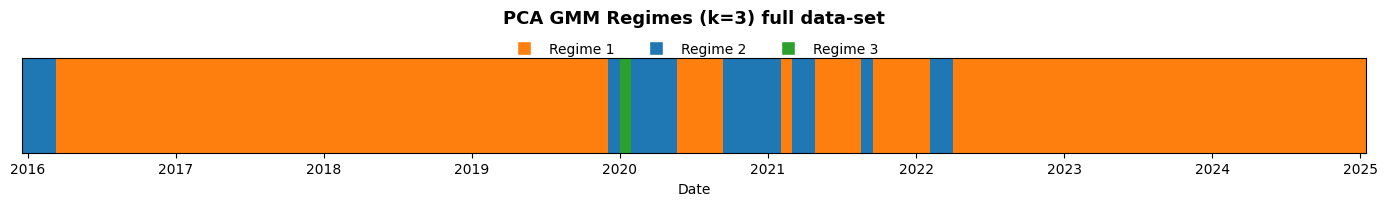

In [602]:
# Grid of candidate numbers of regimes
k_candidates = range(2, 7)
rows = []
models = {}

for k_ in k_candidates:
    # Fit a Gaussian Mixture with k components on PCA-transformed data
    g = GaussianMixture(
        n_components=k_,
        n_init=30,         
        covariance_type="diag",
        reg_covar=1e-6,
        random_state=42
    ).fit(fred_PCA)

    # Standard information criteria
    aic = g.aic(fred_PCA)
    bic = g.bic(fred_PCA)

    # Posterior probabilities and entropy term
    tau = np.clip(g.predict_proba(fred_PCA), 1e-12, 1.0)
    entropy = -np.sum(tau * np.log(tau))    # >= 0

    # Integrated Completed Likelihood (ICL): lower is better
    icl = bic - 2.0 * entropy

    rows.append({
        "k": k_,
        "loglik": g.lower_bound_,           # average log-likelihood
        "AIC": aic,
        "BIC": bic,
        "Entropy": entropy,
        "ICL": icl
    })

    models[k_] = g

# Build DataFrame of criteria
ic_df = pd.DataFrame(rows).set_index("k")

# Manual choice of the number of regimes
chosen_k = 3
gmm = models[chosen_k]

# Check that the GMM converged
if hasattr(gmm, "converged_") and not gmm.converged_:
    print("Warning: GMM did not converge.")

# In-sample predictions (full sample)
labels_tr = gmm.predict(fred_PCA)        # hard regime labels (0..K-1)
probas_tr = gmm.predict_proba(fred_PCA)  # soft regime probabilities
llk_tr    = gmm.score_samples(fred_PCA)  # pointwise log-likelihood

# Build a labelled time series for plotting / analysis
reg_gmm = pd.Series(labels_tr, index=fred_PCA.index, name="gmm_label").astype(int)
reg_gmm = reg_gmm + 1   # shift to start at 1 instead of 0


# ==========================
# Plot regimes only from 2016
# ==========================

# Make sure the index is datetime-like
reg_gmm = reg_gmm.sort_index()
reg_gmm_plot = reg_gmm.loc[reg_gmm.index >= "2016-01-01"]

labels = reg_gmm_plot.values
dates  = reg_gmm_plot.index

# Number of regimes (global, from full sample)
n_regimes = reg_gmm.max()

# Use 0..K-1 as values for the colormap, but keep labels as 1..K
Z = (labels - 1).reshape(1, -1)

palette = sns.color_palette("tab10", n_colors=n_regimes)
random.shuffle(palette)
cmap = ListedColormap(palette)

plt.figure(figsize=(14, 2.6))

plt.imshow(Z, aspect="auto", cmap=cmap)
plt.yticks([])

# x-axis with a few year ticks between first and last date in the plot
plt.xticks(
    ticks=np.linspace(0, len(dates) - 1, 10),
    labels=pd.to_datetime(
        np.linspace(dates[0].value, dates[-1].value, 10)
    ).strftime("%Y")
)

plt.title(
    f"PCA GMM Regimes (k={n_regimes}) full data-set",
    fontsize=13,
    weight="bold",
    pad=25
)
plt.xlabel("Date")

# Legend: Regime 1..K, using the same colors as the colormap
handles = [
    plt.Line2D(
        [0], [0],
        marker="s",
        color="w",
        label=f"Regime {k}",
        markerfacecolor=palette[k - 1],
        markersize=10
    )
    for k in range(1, n_regimes + 1)
]

plt.legend(
    handles=handles,
    loc="upper center",
    bbox_to_anchor=(0.5, 1.30),
    ncol=n_regimes,
    frameon=False
)

plt.tight_layout(rect=[0, 0, 1, 0.85])
plt.show()
